<a href="https://colab.research.google.com/github/dcownden/PerennialProblemsOfLifeWithABrain/blob/life-is-an-MDP/sequences/P1C4_LifeIsRL/P1C4_Sequence1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

The following is part of a test for an upcoming text book on computational neuroscience from an optimization and learning perspective. The book will start with evolution because ultimately, all aspects of the brain are shaped by evolution and, as we will see, evolution can also be seen as an optimization algorithm. We are sharing it now to get feedback on what works and what does not and the developments we should do.

___
# **1.4.1: Is Life Just One Big Markov Decision Process? Yeah, kind of.**
## Objective:
In this sequence we explore and "solve" a simplified version of our Gridworld within the Markov Decision Process (MDP) framework. MDPs offer a robust and flexible method for rigorously defining and identifying optimal policies across various scenarios. Although the formalism of MDPs may seem complex, its components have straightforward and intuitive meanings. We are already acquainted with the key elements of an MDP:

* Policy: The behavioural rule that maps stimuli to an organism's actions.
* Organism (Agent): The entity that reacts to stimuli and performs actions.
* Actions: The specific responses an organism makes at any moment, guided by its policy.
* Environment: The context in which an organism operates, including the source of stimuli, the rules for state changes in response to actions, and the nature of rewards based on actions and state transitions. Other organisms' policies can influence environmental conditions.
* Reward: An evaluation of the outcomes of an organism's actions, typically considered in evolutionary terms such as survival, reproduction, and offspring survival.
* Markov Process: A framework for understanding stochastic dynamics by dividing the world into possible states and defining transition probabilities between these states. Crucially, these probabilities depend solely on the current state, embodying the Markov property and simplifying analysis. Historical relevance to state dynamics is integrated into the state definition, ensuring a comprehensive state concept.

In the sequence we will introduce the crucial notion of **Value**, which integrates these elements and allows for rigorous optimization. Value reflects the expected total future reward from a specific state under a particular policy. Our focus will be on utilizing Value to determine the optimal policy within an MDP. We'll examine Dynamic Programming, specifically Backward Induction, as a method to determine optimal behavior using Value. Although theoretically ideal, Backward Induction (and Dynamic Programming generally) is often impractical for complex problems due to scalability and computational limits. Despite its practical limitations, Backward Induction provides a strong theoretical foundation for more scalable and hence practical solutions. These practical solutions can then be understood as approximations to the ideal but intractable solution method.

Previously we have also touched upon Partial Observability, i.e. situations where the full state of the environment is not known to the organism. Most organisms are not omniscient, so in some sense partial observability is always the case. For now though we are going to leave Partial Observability aside and focus on the simple case where the state of the world is perfectly known to the organism, to streamline the presentation of Value and Backward Induction.

This all seems a bit much, but as we walk through our simplifed Gridworld example, these concepts will become more accessible and less daunting than they might initially appear. We promise.


# Setup

In [1]:
# @title Dependencies, Imports and Setup
# @markdown You don't need to worry about how this code works – but you do need to **run the cell**
!apt install libgraphviz-dev > /dev/null 2> /dev/null #colab
!pip install ipympl pygraphviz vibecheck datatops jupyterquiz > /dev/null 2> /dev/null #google.colab

import requests
from requests.exceptions import RequestException
import numpy as np
import itertools
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
from matplotlib.animation import FuncAnimation
import seaborn as sns
import pandas as pd
import pygraphviz as pgv
import ipywidgets as widgets
import time
import logging
import random
import os
import copy
import torch
import warnings
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from io import BytesIO
from enum import Enum
from scipy.spatial.distance import cdist
from scipy.stats import norm
from scipy.optimize import minimize
from sklearn.linear_model import LinearRegression
from tabulate import tabulate
from IPython.display import display, clear_output, Markdown, HTML, Image, IFrame
from jupyterquiz import display_quiz
from vibecheck import DatatopsContentReviewContainer
from pathlib import Path
from typing import List, Dict
from tqdm.notebook import tqdm

import warnings
warnings.filterwarnings("ignore", category=UserWarning, module="matplotlib")
# random seed settings and
# getting torch to use gpu if it's there


def set_seed(seed=None, seed_torch=True):
  """
  Function that controls randomness. NumPy and random modules must be imported.

  Args:
    seed : Integer
      A non-negative integer that defines the random state. Default is `None`.
    seed_torch : Boolean
      If `True` sets the random seed for pytorch tensors, so pytorch module
      must be imported. Default is `True`.

  Returns:
    Nothing.
  """
  if seed is None:
    seed = np.random.choice(2 ** 32)
  random.seed(seed)
  np.random.seed(seed)
  if seed_torch:
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.benchmark = False
    torch.backends.cudnn.deterministic = True

  print(f'Random seed {seed} has been set.')


def seed_worker(worker_id):
  """
  DataLoader will reseed workers following randomness in
  multi-process data loading algorithm.

  Args:
    worker_id: integer
      ID of subprocess to seed. 0 means that
      the data will be loaded in the main process
      Refer: https://pytorch.org/docs/stable/data.html#data-loading-randomness for more details

  Returns:
    Nothing
  """
  worker_seed = torch.initial_seed() % 2**32
  np.random.seed(worker_seed)
  random.seed(worker_seed)


def set_device():
  """
  Set the device. CUDA if available, CPU otherwise

  Args:
    None

  Returns:
    Nothing
  """
  device = "cuda" if torch.cuda.is_available() else "cpu"
  if device != "cuda":
    print("This notebook isn't using and doesn't need a GPU. Good.")
  else:
    print("GPU is enabled in this notebook but not needed.")
    print("If possible, in the menu under `Runtime` -> ")
    print("`Change runtime type.`  select `CPU`")

  return device


SEED = 2021
set_seed(seed=SEED)
DEVICE = set_device()


def printmd(string):
  display(Markdown(string))


# the different utility .py files used in this notebook
filenames = ['gw_plotting.py', 'gw_board.py', 'gw_game.py',
             'gw_widgets.py', 'gw_NN_RL.py']
#filenames = []
# just run the code straight out of the response, no local copies needed!
for filename in filenames:
  url = f'https://raw.githubusercontent.com/dcownden/PerennialProblemsOfLifeWithABrain/main/utils/{filename}'
  response = requests.get(url)
  # Check that we got a valid response
  if response.status_code == 200:
    code = response.content.decode()
    exec(code)
  else:
    print(f'Failed to download {url}')

# environment contingent imports
try:
  print('Running in colab')
  from google.colab import output
  output.enable_custom_widget_manager()
  from google.colab import data_table
  data_table.disable_dataframe_formatter()
  #from google.colab import output as colab_output
  #colab_output.enable_custom_widget_manager()
  IN_COLAB = True
except:
  IN_COLAB = False
  print('Not running in colab')

%matplotlib inline
%config InlineBackend.figure_format = 'retina'
%matplotlib widget
plt.style.use("https://raw.githubusercontent.com/dcownden/PerennialProblemsOfLifeWithABrain/main/pplb.mplstyle")
plt.ioff() #need to use plt.show() or display explicitly
logging.getLogger('matplotlib.font_manager').setLevel(logging.ERROR)


def content_review(notebook_section: str):
  return DatatopsContentReviewContainer(
    "",  # No text prompt
    notebook_section,
    {
      "url": "https://pmyvdlilci.execute-api.us-east-1.amazonaws.com/klab",
      "name": "neuro_book",
      "user_key": "xuk960xj",
    },
  ).render()
feedback_prefix = "P1C2_S3"




################################################################
# Graph Viz Helper Functions
################################################################
# @title Graphvis Helper Functions


def latex_to_png(latex_str, file_path, dpi, fontsize, figsize):
  """Convert a LaTeX string to a PNG image."""
  fig, ax = plt.subplots(figsize=figsize)
  ax.text(0.5, 0.5, f"${latex_str}$", size=fontsize, ha='center', va='center')
  ax.axis("off")
  #plt.tight_layout()
  plt.subplots_adjust(left=0, right=1, top=1, bottom=0)
  plt.savefig(file_path, dpi=dpi, bbox_inches='tight', transparent=True, pad_inches=0.02)
  plt.close()

def add_latex_edge_labels(graph, edge_labels, dpi=150, fontsize=16, figsize=(0.4,0.2)):
  """Add LaTeX-rendered images as edge labels using the dummy node approach."""
  for edge in edge_labels:
    src, dest, latex_str = edge
    if graph.has_edge(src, dest):
      img_path = f"{src}_to_{dest}_{latex_str}.png"
      latex_to_png(latex_str, img_path, dpi=dpi, fontsize=fontsize, figsize=figsize)
      dummy_node_name = f"dummy_{src}_{dest}_{latex_str}"
      graph.add_node(dummy_node_name, shape="box", image=img_path, label="")
      graph.delete_edge(src, dest)
      graph.add_edge(src, dummy_node_name, dir="none", weight=10)
      graph.add_edge(dummy_node_name, dest, dir="forward", weight=10)
  return graph

def set_regular_node_sizes(graph, width=1.0, height=1.0):
  """Set the size of regular nodes (excluding dummy label nodes)."""
  for node in graph.nodes():
    if not node.startswith("dummy"):
      node.attr['width'] = width
      node.attr['height'] = height
  return graph


def create_and_render_graph(nodes_list, edges_list, latex_edge_labels,
                            action_nodes = [],
                            node_colors = {},
                            node_labels = {},
                            output_path="graphviz_output.png", dpi=300,
                            figsize=(0.6, 0.3), fontsize=16):
  """
  Create a graph with given nodes, edges, and LaTeX edge labels, then render and save it.

  Parameters:
    nodes_list (list): List of nodes in the graph.
    edges_list (list): List of edges in the graph.
    latex_edge_labels (list): List of tuples containing edge and its LaTeX label.
    output_path (str): Path to save the rendered graph.
    dpi (int): DPI for rendering the graph.
    figsize (tuple): Figure size for the LaTeX labels.

  Returns:
    str: Path to the saved graph image.
  """
  # Graph Creation and Configuration
  G = pgv.AGraph(directed=True, strict=False, rankdir='LR', ranksep=0.5, nodesep=0.5)

  # Add state and decision nodes
  for node in nodes_list:
    shape = "box" if node in action_nodes else "ellipse"  # Use 'box' for decision nodes
    color = node_colors.get(node, "black")
    label = node_labels.get(node, node)
    G.add_node(node, color=color, label=label, shape=shape)

  for edge in edges_list:
    G.add_edge(edge[0], edge[1])

  # Set size for regular nodes and add LaTeX-rendered image labels to the edges
  G = set_regular_node_sizes(G, width=1, height=1)
  G = add_latex_edge_labels(G, latex_edge_labels, dpi=dpi, figsize=figsize, fontsize=fontsize)

  # Additional graph attributes
  G.graph_attr['size'] = "8,8"
  G.graph_attr['dpi'] = str(dpi)

  # Render and save the graph
  G.layout(prog='dot')
  G.draw(output_path)

  return output_path




# @title plotting functions
#################################################
# More plotting functions
#################################################


def plot_directions(fig, ax, loc_prob_dict, critter, deterministic=False,
                    name=None):
  """
  Plot vector field indicating critter direction probabilities.

  Args:
    fig, ax (matplotlib objects): Figure and axes objects for plotting.
    loc_prob_dict (dict): Dictionary with keys as (row, col) location tuples
      and values as lists of direction probabilities corresponding to the
      directions ['right', 'down', 'left', 'up'].
    critter (int): Identifier for which critter directions are associated with.
    deterministic (bool, optional): If True, the probabilities array is
      converted to 1-hot, and the arrows are plotted at the center of the cell
      and are larger. Defaults to False.
  """

  #looks like direction ignores inverted axis
  direction_vectors = {'right': (1, 0), 'down': (0, -1),
                       'left': (-1, 0), 'up': (0, 1)}
  # but offsets need to be aware of inverted
  direction_offsets = {'right': (0.1, 0), 'down': (0, 0.1),
                       'left': (-0.1, 0), 'up': (0, -0.1)}
  # Offsets for each critter type 1 and 2 to be used together, 0 by itself
  critter_offsets = {0: (0, 0), 1: (-0.05, -0.05), 2: (0.05, 0.05)}
  # same logic for colors
  critter_colors = {0: 'black', 1: 'red', 2: 'blue'}
  # Get the offset and color for this critter
  critter_offset = critter_offsets[critter]
  critter_color = critter_colors[critter]

  # Add legend only if critter is not 0
  custom_leg_handles = []
  if critter != 0:
    if name is None:
      name = f'Critter {critter}'
    legend_patch = mpatches.Patch(color=critter_color, label=name)
    # Add the legend for this critter
    custom_leg_handles.append(legend_patch)

  C, R, U, V, A = [], [], [], [], []

  for loc in loc_prob_dict.keys():
    row, col = loc
    probs = loc_prob_dict[loc]
    for dir_key, prob in probs.items():
      C.append(col + critter_offset[0] + direction_offsets[dir_key][0])
      R.append(row + critter_offset[1] + direction_offsets[dir_key][1])
      U.append(direction_vectors[dir_key][0])
      V.append(direction_vectors[dir_key][1])

      if deterministic:
        A.append(1 if prob == max(probs.values()) else 0)
      else:
        A.append(prob)

  linewidth = 1.5 if deterministic else 0.5
  scale = 15 if deterministic else 30

  ax.quiver(C, R, U, V, alpha=A, color=critter_color,
            scale=scale, linewidth=linewidth)
  return fig, ax, custom_leg_handles


def make_grid(num_rows, num_cols, figsize=(7,6), title=None):
  """Plots an n_rows by n_cols grid with cells centered on integer indices and
  returns fig and ax handles for further use
  Args:
    num_rows (int): number of rows in the grid (vertical dimension)
    num_cols (int): number of cols in the grid (horizontal dimension)

  Returns:
    fig (matplotlib.figure.Figure): figure handle for the grid
    ax: (matplotlib.axes._axes.Axes): axes handle for the grid
  """
  # Create a new figure and axes with given figsize
  fig, ax = plt.subplots(figsize=figsize, layout='constrained')
  # Set width and height padding, remove horizontal and vertical spacing
  fig.get_layout_engine().set(w_pad=4 / 72, h_pad=4 / 72, hspace=0, wspace=0)
  # Show right and top borders (spines) of the plot
  ax.spines[['right', 'top']].set_visible(True)
  # Set major ticks (where grid lines will be) on x and y axes
  ax.set_xticks(np.arange(0, num_cols, 1))
  ax.set_yticks(np.arange(0, num_rows, 1))
  # Set labels for major ticks with font size of 8
  ax.set_xticklabels(np.arange(0, num_cols, 1),fontsize=8)
  ax.set_yticklabels(np.arange(0, num_rows, 1),fontsize=8)
  # Set minor ticks (no grid lines here) to be between major ticks
  ax.set_xticks(np.arange(0.5, num_cols-0.5, 1), minor=True)
  ax.set_yticks(np.arange(0.5, num_rows-0.5, 1), minor=True)
  # Move x-axis ticks to the top of the plot
  ax.xaxis.tick_top()
  # Set grid lines based on minor ticks, make them grey, dashed, and half transparent
  ax.grid(which='minor', color='grey', linestyle='-', linewidth=2, alpha=0.5)
  # Remove minor ticks (not the grid lines)
  ax.tick_params(which='minor', bottom=False, left=False)
  # Set limits of x and y axes
  ax.set_xlim(( -0.5, num_cols-0.5))
  ax.set_ylim(( -0.5, num_rows-0.5))
  # Invert y axis direction
  ax.invert_yaxis()
  # If title is provided, set it as the figure title
  if title is not None:
    fig.suptitle(title)
  # Hide header and footer, disable toolbar and resizing of the figure
  fig.canvas.header_visible = False
  fig.canvas.toolbar_visible = False
  fig.canvas.resizable = False
  fig.canvas.footer_visible = False
  # Redraw the figure with these settings
  fig.canvas.draw()
  # Return figure and axes handles for further customization
  return fig, ax


def plot_food(fig, ax, rc_food_loc, food=None, size=None,
              show_food=True):
  """
  Plots "food" on a grid implied by the given fig, ax arguments

  Args:
    fig, ax: matplotlib figure and axes objects
    rc_food_loc: ndarry(int) of shape (N:num_food x 2:row,col)
    food: a handle for the existing food matplotlib PatchCollection object
    if one exists
  Returns:
    a handle for matplotlib PathCollection object of food scatter plot, either
    new if no handle was passed or updated if it was
  """
  # if no PathCollection handle passed in:
  if size is None:
    size=150
  if food is None:
    food = ax.scatter([], [], s=size, marker='o',
                      color='red', label='Food')
  if show_food:
    rc_food_loc = np.array(rc_food_loc, dtype=int)
    #matrix indexing convention is is [row-vertical, col-horizontal]
    #plotting indexing convention is (x-horizontal,y-vertical), hence flip
    food.set_offsets(np.fliplr(rc_food_loc))
  return food


def plot_critters(fig, ax, critter_specs: List[Dict[str, object]],
                  size=None) -> List[Dict[str, object]]:
  """
  Plots multiple types of "critters" on a grid implied by the given
  fig, ax arguments.

  Args:
    fig, ax: matplotlib figure and axes objects.
    critter_specs: List of dictionaries with keys 'location', 'name', 'color',
    'marker', 'int_id', 'rc_critter_loc' and optionally 'handle' for each
    critter.

  Returns:
    Updated critter_specs with handles.
  """
  if size is None:
    size=250
  for spec in critter_specs:
    # Ensure required keys are present
    for key in ['marker', 'color', 'name', 'rc_loc']:
      if key not in spec:
        raise ValueError(f"Key '{key}' missing in critter spec.")
    handle_ = spec.get('handle')
    if handle_ is None:
      handle_ = ax.scatter([], [], s=size, marker=spec['marker'],
                           color=spec['color'], label=spec['name'],
                           edgecolors='white', linewidths=1)
    handle_.set_offsets(np.flip(spec['rc_loc']))
    spec.update({'handle': handle_})
  return critter_specs


def plot_critter(fig, ax, rc_critter_loc,
                 critter=None, critter_name='Critter'):
  """
  Plots "critter" on a grid implied by the given fig, ax arguments

  Args:
    fig, ax: matplotlib figure and axes objects
    rc_critter_loc: ndarry(int) of shape (N:num_critters x 2:row,col)
    critter: a handle for the existing food matplotlib PatchCollection object
    if one exists
  Returns:
    a handle for matplotlib PathCollection object of critter scatter plot,
    either new if no handle was passed in or updated if it was.
  """
  if critter is None:
    critter = ax.scatter([], [], s=250, marker='h',
                         color='blue', label=critter_name)
  # matrix indexing convention is is [row-vertical, col-horizontal]
  # plotting indexing convention is (x-horizontal,y-vertical), hence flip
  critter.set_offsets(np.flip(rc_critter_loc))
  return critter


def plot_fov(fig, ax, rc_critter, n_rows, n_cols, radius, has_fov,
             opaque=False, fov=None):
  """
  Plots a mask on a grid implied by the given fig, ax arguments

  Args:
    fig, ax: matplotlib figure and axes objects
    rc_critter: ndarry(int) (row,col) of the critter
    mask: a handle for the existing mask matplotlib Image object if one exists
  Returns:
    a handle for matplotlib Image object of mask, either new if no handle
    was passed in or updated if it was.
  """

  # Initialize mask as a semi-transparent overlay for the entire grid
  mask_array = np.ones((n_rows, n_cols, 4))
  mask_array[:, :, :3] = 0.5  # light grey color
  if has_fov == True:
    if opaque:
      mask_array[:, :, 3] = 1.0  # 50% opacity
    else:
      mask_array[:, :, 3] = 0.5  # 50% opacity
    # Create arrays representing the row and column indices
    rows = np.arange(n_rows)[:, np.newaxis]
    cols = np.arange(n_cols)[np.newaxis, :]
    # Iterate over each critter location
    dist = np.abs(rows - rc_critter[0]) + np.abs(cols - rc_critter[1])
    # Set the region within the specified radius around the critter to transparent
    mask_array[dist <= radius, 3] = 0
  else:
    mask_array[:, :, 3] = 0

  if fov is None:
    fov = ax.imshow(mask_array, origin='lower', zorder=2)
  else:
    fov.set_data(mask_array)

  return fov


def remove_ip_clutter(fig):
  fig.canvas.header_visible = False
  fig.canvas.toolbar_visible = False
  fig.canvas.resizable = False
  fig.canvas.footer_visible = False
  fig.canvas.draw()








Random seed 2021 has been set.
This notebook isn't using and doesn't need a GPU. Good.
Running in colab


In [2]:
# @title Gridworld Board Class
# Local definition to be put in utils later


class GridworldBoard():
  """
  A collection methods and parameters for our Gridworld game.

  board state is represented by primarily by pieces, scores, rounds_left and is_over

  pieces is a batch x n_rows x n_cols numpy array positive integers are critter
  locations 0's are empty space and negative integers are food. Each critter is
  unique and executing it's own policy so they are non-fungible, whereas food
  (of the same type) is always the same, so there can and typically will be
  duplicates of negative integers in the pieces array, but never of positive
  integers

  For pieces first dim is batch, second dim row , third is col,
  so pieces[0][1][7] is the square in row 2, in column 8 of the first board in
  the batch of boards.

  scores is a batchsize x num_critters numpy array giving the scores for each
  critter on each board in the batch (note off by one indexing)

  rounds_left is how many rounds are left in the game. Each critter gets one
  move per round so this will be the same for every critter in every batch.

  is_over just tracks whether each game in each batch has concluded, this allows
  for probabalistic end times, not just deterministic end times based on moves left

  Note: In this version the game class handles the end conditions, without any
      input from this board class. Even though they are not used, max_rounds_taken
      and end_prob are passed in to the constructor for completeness.

  Note:
    In 2d np.array first dim is row (vertical), second dim is col (horizontal),
    i.e. top left corner is (0,0), so take care when visualizing/plotting
    as np.array visualization is aligned with typical tensor notation but at odds
    with conventional plotting where (0,0) is bottom left, first dim, x, is
    horizontal, second dim, y, is vertical, so we use invert y-axis when plotting
    with matplotlib
  """


  class CritterFoodType(Enum):
    FOOD = "food"
    PREY = "prey"
    PREDATOR = "predator"

  ARRAY_PAD_VALUE = -200


  def __init__(self, batch_size=2,
               n_rows=7, n_cols=7,
               num_foragers=1,
               num_predators=0,
               max_rounds_taken=30,
               end_prob=0.00,
               food_num_deterministic = True,
               food_patch_prob=10.0/49.0,
               food_forager_regen = True,
               rng=None,
               state_elements = ['pieces', 'scores', 'is_over', 'rounds_left'],
               init_board_state = None
               ):

    """Set the parameters of the game."""
    # size of the board/world
    self.n_rows = n_rows
    self.n_cols = n_cols
    self.batch_size = batch_size

    #number and type of critters on the board
    self.num_foragers = num_foragers
    self.num_predators = num_predators
    # foragers will be indicated by lower valued positive integers, predators
    # by higher valued intagers
    self.forager_predator_threshold = self.num_foragers
    self.num_critters = num_foragers + num_predators

    # end conditions can be deterministic or stochastic
    # one of moving, or eating or both might take time, e.g. eating might be
    # automatic and free after moving, conversely, moving might be free, but
    # eating count towards the session/episode ending, or both might
    self.max_rounds_taken = max_rounds_taken
    self.end_prob = end_prob

    # what proportion of the (non-critter occupied) patches contain food.
    self.food_patch_prob = food_patch_prob
    self.food_num_deterministic = food_num_deterministic
    if self.food_num_deterministic:
      self.num_food = int((self.n_rows * self.n_cols - self.num_critters)
                          * self.food_patch_prob)
    self.food_forager_regen = food_forager_regen

    # reproducible stochasticity
    if rng is None:
      self.rng = np.random.default_rng(seed=SEED)
    else:
      self.rng = rng

    self.state_elements = state_elements

    # initialize the board
    if init_board_state is None:
      init_board_state = self.get_init_board_state()

    self.set_state(init_board_state)


  def init_loc(self, n_rows, n_cols, num, rng=None):
    """
    Samples random 2d grid locations without replacement, useful for placing
    critters and food on the board.

    Args:
      n_rows: int, number of rows in the grid
      n_cols: int, number of columns in the grid
      num:    int, number of samples to generate. Should throw an error if num > n_rows x n_cols
      rng:    instance of numpy.random's default rng. Used for reproducibility.

    Returns:
      int_loc: ndarray(int) of shape (num,), flat indices for a 2D grid flattened into 1D
      rc_index: tuple(ndarray(int), ndarray(int)), a pair of arrays with the first giving
        the row indices and the second giving the col indices. Useful for indexing into
        an n_rows by n_cols numpy array.
      rc_plotting: ndarray(int) of shape (num, 2), 2D coordinates suitable for matplotlib plotting
    """

    # Set up default random generator, use the boards default if none explicitly given
    if rng is None:
      rng = self.rng
    # Choose 'num' unique random indices from a flat 1D array of size n_rows*n_cols
    int_loc = rng.choice(n_rows * n_cols, num, replace=False)
    # Convert the flat indices to 2D indices based on the original shape (n_rows, n_cols)
    rc_index = np.unravel_index(int_loc, (n_rows, n_cols))
    # Transpose indices to get num x 2 array for easy plotting with matplotlib
    rc_plotting = np.array(rc_index).T
    # Return 1D flat indices, 2D indices for numpy array indexing and 2D indices for plotting
    return int_loc, rc_index, rc_plotting


  def get_init_board_state(self):
    """
    Set up starting board using game parameters
    """
    state = {}
    state['rounds_left'] = (np.ones(self.batch_size) *
                           self.max_rounds_taken)
    state['is_over'] = np.zeros(self.batch_size, dtype=bool)
    state['scores'] = np.zeros((self.batch_size, self.num_critters))

    # create an empty board array.
    pieces = np.zeros((self.batch_size, self.n_rows, self.n_cols),
                       dtype=int)
    # Place critter and initial food items on the board randomly
    if self.food_num_deterministic:
      init_food_nums = [self.num_food] * self.batch_size
    else:
      init_food_nums = self.rng.binomial(self.n_rows * self.n_cols - self.num_critters,
                                         self.food_patch_prob, size=self.batch_size)
    # place food and critters randomly
    for ii in np.arange(self.batch_size):
      # num_food+num_critter because we want critter and food locations
      int_loc, rc_idx, rc_plot = self.init_loc(
        self.n_rows, self.n_cols, init_food_nums[ii]+self.num_critters)
      # critter random start locations
      for c_ in np.arange(self.num_critters):
        pieces[(ii, rc_idx[0][c_], rc_idx[1][c_])] = c_ + 1
      # food random start locations
      for f_ in np.arange(init_food_nums[ii]):
        pieces[(ii, rc_idx[0][self.num_critters + f_],
                    rc_idx[1][self.num_critters + f_])] = -f_ - 1
    state['pieces'] = pieces
    return state


  def set_state(self, board, check=False):
    """ board is dictionary giving game state """
    if check:
      if board['pieces'].shape != (self.batch_size, self.n_rows, self.n_cols):
        raise ValueError("Invalid shape for 'pieces'")
      if board['scores'].shape != (self.batch_size, self.num_crititters):
        raise ValueError("Invalid shape for 'scores'")
      if board['rounds_left'].shape != (self.batch_size,):
        raise ValueError("Invalid shape for 'rounds_left'")
      if board['is_over'].shape != (self.batch_size,):
        raise ValueError("Invalid shape for 'is_over'")
    for key in self.state_elements:
      if key in board:
        setattr(self, key, board[key].copy())
      else:
        raise ValueError(f"Key '{key}' not found in the provided board state.")


  def get_state(self):
    """ returns a board state dictionary"""
    state = {key: getattr(self, key).copy() for key in self.state_elements}
    return state


  def __getitem__(self, index):
    return self.pieces[index]


  def get_critter_food_type(self, critter_food):
    if critter_food <= -1:
        critter_food_type = self.CritterFoodType.FOOD
    elif critter_food > self.forager_predator_threshold:
        critter_food_type = self.CritterFoodType.PREDATOR
    else:
        critter_food_type = self.CritterFoodType.PREY
    return critter_food_type


  def get_type_masks(self):
    """
    Returns masks indicating the position types on the board.
    Returns:
        tuple: Tuple containing masks for empty spaces, food, prey, and predator.
    """
    empt_mask = self.pieces == 0
    food_mask = self.pieces <= -1
    prey_mask = (1 <= self.pieces) & (self.pieces <= self.forager_predator_threshold)
    pred_mask = self.forager_predator_threshold < self.pieces
    return empt_mask, food_mask, prey_mask, pred_mask


  def get_collisions(self, moves, critter_food, critter_food_type):
    """
    Determine the collision results and update scores accordingly.
    Args:
        moves (tuple): Tuple of arrays indicating the moves.
        critter_food (int): Index to identify the critter or food.
        critter_food_type (enum): Type of the critter or food
    Returns:
        tuple: Tuple containing move collision messages and separates out the
        moves by where they land i.e., empty spaces, food, prey, and predator.
    """
    batch_size, n_rows, n_cols = self.pieces.shape
    move_mask = np.zeros(self.pieces.shape, dtype=bool)
    move_mask[moves] = True
    (empt_mask, food_mask,
     prey_mask, pred_mask) = self.get_type_masks()

    move_coll_msg = np.zeros(batch_size)
    empt_moves = np.where(empt_mask & move_mask)
    food_moves = np.where(food_mask & move_mask)
    prey_moves = np.where(prey_mask & move_mask)
    pred_moves = np.where(pred_mask & move_mask)
    move_coll_msg[empt_moves[0]] = 1

    if critter_food_type == self.CritterFoodType.PREY:
      move_coll_msg[food_moves[0]] = 2
    elif critter_food_type == self.CritterFoodType.PREDATOR:
      move_coll_msg[food_moves[0]] = 3
      move_coll_msg[prey_moves[0]] = 4
    # all collision types are blocking for food types

    return (move_coll_msg, empt_moves, food_moves, prey_moves, pred_moves)


  def update_scores(self, move_coll_msg, critter_food,
                    critter_food_type, prey_moves):
    if critter_food_type == self.CritterFoodType.PREY:
      self.scores[:, critter_food-1] += (move_coll_msg == 2)
    elif critter_food_type == self.CritterFoodType.PREDATOR:
      # predators that eat get a point
      self.scores[:, critter_food-1] += (move_coll_msg == 4)
      # prey that are eaten lose 10 points
      who_eaten = self.pieces[prey_moves]
      self.scores[prey_moves[0], who_eaten-1] -= 10
    # food types don't get a score, it's a neuro book


  def move_pieces(self, critter_food, move_coll_msg, moves):
    """
    Move the pieces on the board based on the collision messages.

    Args:
        critter_food (int): Index to identify the critter or food.
        move_coll_msg (np.array): Array of collision messages.
        moves (tuple): Tuple of arrays indicating the moves.
    """
    old_locs = np.where(self.pieces == critter_food)
    vacated_old_locs = np.column_stack(old_locs)[np.where(move_coll_msg > 0)]
    vacated_old_locs_idx = (vacated_old_locs[:,0],
                            vacated_old_locs[:,1],
                            vacated_old_locs[:,2])
    self.pieces[vacated_old_locs_idx] = 0
    new_locs = np.column_stack(moves)[np.where(move_coll_msg > 0)]
    new_locs_idx = (new_locs[:,0], new_locs[:,1], new_locs[:,2])
    self.pieces[new_locs_idx] = critter_food


  def replace_destroyed(self, destroying_moves, old_pieces):
    """
    Replace the destroyed pieces on the board.

    Args:
        destroying_moves (tuple): Tuple of arrays indicating the moves that
        resulted in destruction.
    """
    batch_size, n_rows, n_cols = old_pieces.shape
    g_gone = np.zeros(batch_size)
    g_gone[destroying_moves[0]] = 1
    which_gone = old_pieces[destroying_moves]
    if np.sum(g_gone) > 0:
      num_empty_after = (n_rows*n_cols - self.num_food - self.num_critters + 1)
      p_new_locs = np.where(np.logical_and(
        self.pieces == 0, g_gone.reshape(batch_size, 1, 1)))
      food_sample_ = self.rng.choice(num_empty_after, size=int(np.sum(g_gone)))
      food_sample = food_sample_ + np.arange(int(np.sum(g_gone)))*num_empty_after
      new_loc_vals = self.pieces[(p_new_locs[0][food_sample],
                   p_new_locs[1][food_sample],
                   p_new_locs[2][food_sample])]
      # this requires that p_new_locs and destroying moves are both
      # lexographically sorted... but they are not always
      self.pieces[(p_new_locs[0][food_sample],
                   p_new_locs[1][food_sample],
                   p_new_locs[2][food_sample])] = which_gone


  def execute_moves(self, moves, critter_food):
    """
    Execute the moves on the board, handle collisions, update scores,
    and replace destroyed/eaten pieces.

    Args:
      moves (tuple): Tuple of arrays indicating the moves.
      critter_food (int): Index to identify the critter or food.
    """
    # what type of critter is moving
    critter_food_type = self.get_critter_food_type(critter_food)
    # what do they land on when they move
    (move_coll_msg, empt_moves, food_moves,
     prey_moves, pred_moves) = self.get_collisions(
        moves, critter_food, critter_food_type)
    # based on what they move onto increment/decrement scores
    self.update_scores(move_coll_msg, critter_food,
                       critter_food_type, prey_moves)
    # move the pieces
    old_pieces = self.pieces.copy()
    self.move_pieces(critter_food, move_coll_msg, moves)
    # eaten/destroyed food and prey respawn in some variants
    if critter_food_type == self.CritterFoodType.PREY:
      if self.food_forager_regen:
        self.replace_destroyed(food_moves, old_pieces)
    elif critter_food_type == self.CritterFoodType.PREDATOR:
      if self.food_forager_regen:
        self.replace_destroyed(food_moves, old_pieces)
        self.replace_destroyed(prey_moves, old_pieces)

    if self.food_forager_regen:
      check_sum = np.sum(np.arange(start=-self.num_food,
                                   stop=self.num_critters+1))
      if np.any(np.sum(self.pieces, axis=(1,2)) != check_sum):
        print('something went terribly wrong')
        print(old_pieces)
        print(critter_food)
        print(moves)
        print(self.pieces)


  def get_neighbor_grc_indices(self, critter_food, radius, pad=False):
    """
    Returns all grid positions within a certain cityblock distance radius from
    the place corresponding to critter_food.

    Args:
        critter_food (int): The idex of the focal critter_food.
        radius (int): The cityblock distance.
        pad (bool): whether or not to pad the array, if padded all row, col
          indexes are valid for the padded array, useful for getting percept
          if not all indexes are correct for the original array, useful for
          figuring out legal moves.

    Returns:
        an array of indices, each row is a g, r, c index for the neighborhoods
        around the critters, can use the g value to know which board you are in.
        if pad=True also returns the padded array (the indices in that case) are
        for the padded array, so won't work on self.pieces, whereas if pad is
        False the indices will be for the offsets in reference to the original
        self.pieces, but note that some of these will be invalid, and will
        need to be filtered out (as we do in get_legal)
    """
    batch_size, n_rows, n_cols = self.pieces.shape
    # Create meshgrid for offsets
    if pad is True:
      padded_arr = np.pad(self.pieces, ((0, 0), (radius, radius),
        (radius, radius)), constant_values=self.ARRAY_PAD_VALUE)
      batch, rows, cols = np.where(padded_arr == critter_food)
    else:
      batch, rows, cols = np.where(self.pieces == critter_food)
    row_offsets, col_offsets = np.meshgrid(
        np.arange(-radius, radius + 1),
        np.arange(-radius, radius + 1),
        indexing='ij')

    # Filter for valid cityblock distances
    mask = np.abs(row_offsets) + np.abs(col_offsets) <= radius
    valid_row_offsets = row_offsets[mask]
    valid_col_offsets = col_offsets[mask]
    # Extend rows and cols dimensions for broadcasting
    extended_rows = rows[:, np.newaxis]
    extended_cols = cols[:, np.newaxis]
    # Compute all neighbors for each position in the batch
    neighbors_rows = extended_rows + valid_row_offsets
    neighbors_cols = extended_cols + valid_col_offsets

    indices = np.column_stack((np.repeat(np.arange(batch_size),
                                         neighbors_rows.shape[1]),
                               neighbors_rows.ravel(),
                               neighbors_cols.ravel()))
    if pad is False:
      return indices
    elif pad is True:
      return indices, padded_arr


  def get_legal_moves(self, critter_food, radius=1):
    """
    Identifies all legal moves for the critter, taking into acount which moves
    are blocking based on type.

    Returns:
      A numpy int array of size batch x 3(g,x,y) x 4(possible moves)

    Note:
      moves[0,1,3] is the x coordinate of the move corresponding to the
      fourth offset on the first board.
      moves[1,:,1] will give the g,x,y triple corresponding to the
      move on the second board and the second offset, actions are integers
    """

    critter_locs = np.array(np.where(self.pieces == critter_food))
    # turn those row, col offsets into a set of legal offsets
    legal_offsets = self.get_neighbor_grc_indices(critter_food, radius)
    legal_offsets = {tuple(m_) for m_ in legal_offsets}

    # Apply logic of where a successful move can be made, by which
    # type of critter, be they food, prey, predator or something else
    empt_mask, food_mask, prey_mask, pred_mask = self.get_type_masks()
    critter_food_type = self.get_critter_food_type(critter_food)
    #print(critter_food_type)
    if critter_food_type == self.CritterFoodType.FOOD:
      #food only drifts into empty places
      legal_destinations = np.where(empt_mask)
    elif critter_food_type == self.CritterFoodType.PREY:
      legal_destinations = np.where(empt_mask | food_mask)
    elif critter_food_type == self.CritterFoodType.PREDATOR:
      legal_destinations = np.where(empt_mask | food_mask | prey_mask)
    else:
      raise ValueError("Unexpected value for critter_food_type.")
    legal_destinations = {tuple(coords) for coords in zip(*legal_destinations)}
    # Add the current locations of the critters to legal_destinations
    current_locations = {tuple(loc) for loc in critter_locs.T}
    legal_destinations = legal_destinations.union(current_locations)

    # legal moves are both legal offsets and legal destinations
    legal_moves = legal_offsets.intersection(legal_destinations)
    return legal_moves


  def get_legal_offsets(self, critter_food, radius):
    """
    Identifies all legal offsets for a critter or food, so filter out moves
    that are off the board, but does not filter out collisions that would be
    blocking. For a random valid player likely better to use get_legal_moves,
    but this is much quicker, because it doesn't check collision types, for
    use by RL agents in training loops

    Returns:
      A numpy int array of size batch x 3(g,x,y) x 4(possible moves)

    Note:
      moves[0,1,3] is the x coordinate of the move corresponding to the
      fourth offset on the first board.
      moves[1,:,1] will give the g,x,y triple corresponding to the
      move on the second board and the second offset, actions are integers
    """
    batch_size, n_rows, n_cols = self.pieces.shape
    batch, rows, cols = np.where(self.pieces == critter_food)
    row_offsets, col_offsets = np.meshgrid(
        np.arange(-radius, radius + 1),
        np.arange(-radius, radius + 1),
        indexing='ij')
    # Filter for valid cityblock distances
    mask = np.abs(row_offsets) + np.abs(col_offsets) <= radius
    valid_row_offsets = row_offsets[mask]
    valid_col_offsets = col_offsets[mask]
    # Extend rows and cols dimensions for broadcasting
    extended_rows = rows[:, np.newaxis]
    extended_cols = cols[:, np.newaxis]
    # Compute all neighbors for each position in the batch
    potential_moves_rows = extended_rows + valid_row_offsets
    potential_moves_cols = extended_cols + valid_col_offsets

    # Filter offsets that would take the critter outside the board
    c1 = potential_moves_rows >= 0
    c2 = potential_moves_rows <= n_rows-1
    c3 = potential_moves_cols >= 0
    c4 = potential_moves_cols <= n_cols-1
    valid_move_mask = np.logical_and.reduce([c1, c2, c3, c4])

    legal_offsets_rows = potential_moves_rows[valid_move_mask]
    legal_offsets_cols = potential_moves_cols[valid_move_mask]
    batch_indexes = np.repeat(batch, valid_row_offsets.shape[0])
    legal_offsets = np.column_stack((batch_indexes[valid_move_mask.ravel()],
                                     legal_offsets_rows.ravel(),
                                     legal_offsets_cols.ravel()))
    return legal_offsets, valid_move_mask


  def get_perceptions(self, critter_food, radius):
    idx, pad_pieces = self.get_neighbor_grc_indices(critter_food,
                                                    radius, pad=True)
    #percept_mask = np.zeros(pad_pieces.shape, dtype=bool)
    #percept_mask[idx[:,0], idx[:,1]], idx[:,2]] = True
    percept = pad_pieces[idx[:,0], idx[:,1], idx[:,2]]
    return(percept.reshape(self.batch_size, -1))


  def execute_drift(self, offset_probs, wrapping=False):
    """
    Drift the food on the board based on the given offsets probabilities.
    Collisions handled by checking possible new locations in a random order and
    cancelling moves that result in a collision.

    Parameters:
    - offset_probs: Probabilities corresponding to each offset, note implicit
    order dependence here


    Returns:
    - nothing, just updates self.pieces
    """
    # Check the length of offset_probs
    #if len(offset_probs) != 5:
    #    raise ValueError("offset_probs should be of length 5.")
    # Check if values are non-negative
    #if any(p < 0 for p in offset_probs):
    #    raise ValueError("All probabilities in offset_probs should be non-negative.")
    # Normalize the probabilities
    #offset_probs = np.array(offset_probs) / np.sum(offset_probs)
    # Convert offsets to a 2D numpy array
    possible_offsets = np.array([[ 0, -1,  0], # up
                                 [ 0,  1,  0], # down
                                 [ 0,  0, -1], # left
                                 [ 0,  0,  1], # right
                                 [ 0,  0,  0]]) # still
    batch_size, n_rows, n_cols = self.pieces.shape
    # original food locations
    food_locations = np.argwhere(self.pieces == -1)
    # Sample offsets for each food location
    num_food = food_locations.shape[0]
    sampled_offsets = possible_offsets[self.rng.choice(
        np.arange(possible_offsets.shape[0]),
        size=num_food, replace=True, p=offset_probs)]
    # Possible new food locations
    possible_new_locations = food_locations + sampled_offsets
    possible_wrap_row_indexes = self.rng.choice(np.arange(n_rows),
                                                size=num_food)
    possible_wrap_col_indexes = self.rng.choice(np.arange(n_cols),
                                                size=num_food)

    # Randomly iterate through the possible new locations
    random_order = np.random.permutation(num_food)
    for idx in random_order:
      g, r, c = possible_new_locations[idx]
      # Check if the new location is inside the boundaries of the board
      if 0 <= r < self.pieces.shape[1] and 0 <= c < self.pieces.shape[2]:
        # Check if the new location is empty or contains a critter
        if self.pieces[g, r, c] == 0:
          # Update the board
          old_g, old_r, old_c = food_locations[idx]
          self.pieces[g, r, c] = -1
          self.pieces[old_g, old_r, old_c] = 0
      elif wrapping == True:
        # If wrapping is on then food can drift off the edge of the board and
        # 'new' food will appear in a random loc on the opposite side
        # Determine the opposite edge
        if r < 0:  # Top edge
          opposite_r = n_rows - 1
          opposite_c = possible_wrap_col_indexes[idx]
        elif r >= n_rows:  # Bottom edge
          opposite_r = 0
          opposite_c = possible_wrap_col_indexes[idx]
        elif c < 0:  # Left edge
          opposite_c = n_cols - 1
          opposite_r = possible_wrap_row_indexes[idx]
        elif c >= n_cols:  # Right edge
          opposite_c = 0
          opposite_r = possible_wrap_row_indexes[idx]

        # Check if the opposite location is unoccupied
        if self.pieces[g, opposite_r, opposite_c] == 0:
          old_g, old_r, old_c = food_locations[idx]
          self.pieces[g, opposite_r, opposite_c] = -1
          self.pieces[old_g, old_r, old_c] = 0




In [3]:
b = GridworldBoard()

In [4]:
b.get_state()

{'pieces': array([[[ 0,  0,  0,  0,  0,  0,  0],
         [ 0,  0,  0,  0,  0,  0,  0],
         [-4,  0,  0,  0,  0,  0, -7],
         [ 0,  0,  0, -1,  0, -9,  0],
         [ 0, -5, -8, -6,  0,  0,  0],
         [ 0,  0,  0,  0,  0, -2,  0],
         [ 0,  0,  0,  0,  0, -3,  1]],
 
        [[ 0,  0, -2,  1,  0,  0, -8],
         [ 0,  0, -3,  0,  0, -4, -1],
         [ 0,  0,  0,  0,  0,  0,  0],
         [ 0,  0,  0,  0,  0, -9,  0],
         [-6,  0,  0,  0,  0,  0,  0],
         [ 0,  0,  0,  0, -7,  0,  0],
         [ 0, -5,  0,  0,  0,  0,  0]]]),
 'scores': array([[0.],
        [0.]]),
 'is_over': array([False, False]),
 'rounds_left': array([30., 30.])}

In [5]:
b.get_legal_moves(1)

{(0, 5, 6), (0, 6, 5), (0, 6, 6), (1, 0, 2), (1, 0, 3), (1, 0, 4), (1, 1, 3)}

In [6]:
b.execute_moves(([0,1], [5,0], [6,2]), 1)

In [7]:
b.get_state()

{'pieces': array([[[ 0,  0,  0,  0,  0,  0,  0],
         [ 0,  0,  0,  0,  0,  0,  0],
         [-4,  0,  0,  0,  0,  0, -7],
         [ 0,  0,  0, -1,  0, -9,  0],
         [ 0, -5, -8, -6,  0,  0,  0],
         [ 0,  0,  0,  0,  0, -2,  1],
         [ 0,  0,  0,  0,  0, -3,  0]],
 
        [[ 0,  0,  1,  0,  0,  0, -8],
         [ 0,  0, -3,  0,  0, -4, -1],
         [ 0, -2,  0,  0,  0,  0,  0],
         [ 0,  0,  0,  0,  0, -9,  0],
         [-6,  0,  0,  0,  0,  0,  0],
         [ 0,  0,  0,  0, -7,  0,  0],
         [ 0, -5,  0,  0,  0,  0,  0]]]),
 'scores': array([[0.],
        [1.]]),
 'is_over': array([False, False]),
 'rounds_left': array([30., 30.])}

In [64]:
# @title GridworldGame class
#######################################################################
# extend GridworldGame class locally before integrating in shared utils
#######################################################################



class GridworldGame():
  """
  A collection methods and parameters of a gridworld game that allow
  for interaction with and display of GridwordlBoard objects.
  """


  def __init__(self, batch_size=2,
               n_rows=7, n_cols=7,
               num_foragers=1,
               num_predators=0,
               max_rounds_taken=30,
               end_prob=0.00,
               food_num_deterministic = True,
               food_patch_prob=10.0/48.0,
               food_forager_regen = True,
               rng=None,
               state_elements = ['pieces', 'scores', 'is_over', 'rounds_left'],
               init_board_state = None,
               drift_player = None):

    """
    Initializes an instance of the class with the specified parameters.
    Args:
      batch_size (int, optional): Number of instances in a batch. Default is 1.
      n_rows (int, optional): Number of rows in the grid. Default is 7.
      n_cols (int, optional): Number of columns in the grid. Default is 7.
      num_foragers (int, optional): Number of different agents running around
        on each board in the batch eating food. Default is 1.
      num_predators (int, optional): Number of different agents running around
        on each board in the batch eating foragers. Default is 0.
      max_rounds_taken (int, optional): Time before critter's foraging session
        ends, in terms of moves taken. Default is 30.
      end_prob (float, optional): Probability of ending the game before max
        moves are taken, on a given round. Default is 0.00.
      food_num_deterministic (bool, optional): Whether or not the number of food
        items on each board is deterministic. Default is True.
      food_patch_prob (float, optional): Probability of food appearing on each
        non-critter-occupied grid cell. Default is 10.0/49.
        If food_num_determinisitc is true we use the expected value for each
        game in the batch
      food_forager_regen (bool, optional): Whether or not foragers and food
        respawn/regenerate after they are eaten/destroyed. Default is True.
      rng (numpy random number generator, optional): Random number generator
        for reproducibility. If None, uses default RNG with a preset seed.
      state_elements (list of strings, optional): Elements of the state
        passed to players to determine moves. Default is ['pieces', 'scores',
        'is_over', 'rounds_left'].
      init_board_state (dict, optional): Allows for manual game state
        initilization. Default is None, resulting in a random initialization.
      drift_player (player object, optional): a 'player' who moves the food
        pieces around (drifting) if none, skip food movement

    Note: In this version game class handles the end conditions, without any
      input from the board class.
    """

    # Check for positive integer inputs
    assert all(isinstance(i, int) and i >= 0
               for i in [batch_size, n_rows, n_cols, num_foragers,
                         num_predators, max_rounds_taken]), "These inputs must be non-negative integers."

    if rng is None:
      self.rng = np.random.default_rng(seed=SEED)
    else:
      self.rng = rng

    self.batch_size = batch_size
    self.n_rows = n_rows
    self.n_cols = n_cols
    self.num_foragers = num_foragers
    self.num_predators = num_predators
    self.num_critters = num_predators + num_foragers
    self.pred_prey_threshold = self.num_foragers
    self.max_rounds_taken = max_rounds_taken
    self.end_prob = end_prob
    self.food_num_deterministic = food_num_deterministic
    self.food_patch_prob = food_patch_prob
    self.food_forager_regen = food_forager_regen
    self.drift_player = drift_player
    self.init_board_state = init_board_state
    self.state_elements = state_elements

    # convience wrapper for passing parameters to board class constructor
    self.board_params = {
      'batch_size': self.batch_size,
      'n_rows': self.n_rows,
      'n_cols': self.n_cols,
      'num_foragers': self.num_foragers,
      'num_predators': self.num_predators,
      'max_rounds_taken': self.max_rounds_taken,
      'end_prob': self.end_prob,
      'food_num_deterministic': self.food_num_deterministic,
      'food_patch_prob': self.food_patch_prob,
      'food_forager_regen': self.food_forager_regen,
      'rng': self.rng,
      'state_elements': self.state_elements
    }

  def get_init_board(self):
    """
    Generates a starting board given the parameters of the game.
    Returns a tuple giving current state of the game
    """
    # current score, and rounds left in the episode
    b = GridworldBoard(**self.board_params,
                       init_board_state=self.init_board_state)
    return b.get_state()


  def get_board_shape(self):
    """Shape of a single board, doesn't give batch size"""
    return (self.n_rows, self.n_cols)


  def get_action_size(self):
    """
    Returns the number of all possible actions, even though only  2-4 of
    these will ever be valid on a given turn.
    Actions correspond to integer indexes of board locations,
    moves to g,r,c coordinate indexes of board locations
    """
    return self.n_rows * self.n_cols


  def get_batch_size(self):
    """
    Returns the number of actions, only 0-4 of these will ever be valid.
    Actions correspond to integer indexes of board locations,
    moves to r,c indexes of board locations
    """
    return self.batch_size


  def string_rep(self, board, g=0):
    """ A bytestring representation board g's state in the batch of boards"""
    return (board['pieces'][g].tobytes() + board['scores'][g].tobytes() +
            board['rounds_left'][g].tobytes())


  def get_square_symbol(self, piece):
    """ Translate integer piece value to symbol for display"""
    if piece <= -1:
      return "X"
    elif piece == 0:
      return "-"
    elif piece >= 1:
      return "0"
    else:
      return "???????????????????????????"


  def string_rep_readable(self, board, g=0):
    """ A human readable representation of g-th board's state in the batch"""
    board_s = "".join([self.get_square_symbol(square)
                        for row in board['pieces'][g]
                          for square in row])
    board_s = board_s + '_' + str(board['scores'][g])
    board_s = board_s + '_' + str(board['rounds_left'][g])
    return board_s


  def get_scores(self, board):
    return board['scores'].copy()


  def get_rounds_left(self, board):
    return board['rounds_left'].copy()


  def display(self, board, g=0):
    """Displays the g-th games in the batch of boards"""
    print("   ", end="")
    for c_ in range(self.n_cols):
      print(c_, end=" ")
    print("")
    print("-----------------------")
    for r_ in range(self.n_rows):
      print(r_, "|", end="")    # Print the row
      for c_ in range(self.n_cols):
        piece = board['pieces'][g,r_,c_]    # Get the piece to print
        #print(piece)
        print(self.get_square_symbol(piece), end=" ")
      print("|")
    print("-----------------------")
    print("Rounds Left: " + str(board['rounds_left'][g]))
    print("Score: " + str(board['scores'][g]))


  def get_critter_rc(self, board, g, critter_index):
    return np.squeeze(np.array(np.where(board['pieces'][g]==critter_index)))


  def plot_moves(self, board, player0, g=0, player1=None,
                 fig=None, ax=None, p0_name='Player 0', p1_name='Player 1',
                 figsize=(6,5), critter_name='Critter', title=None,
                 deterministic=False):
    """
    Uses plotting functions to make picture of the current board state, and what
    a critter would do at each non-food location in the current board state
    """
    def make_prob_dict(critter_locs, play):
      offset_dict = {(0, 1): 'right',
                     (0,-1): 'left',
                     ( 1, 0): 'down',
                     (-1, 0): 'up'}
      index_probs = play[2].copy()
      loc_prob_dict = {}
      # for each non food locations
      for g, loc_ in enumerate(critter_locs):
        # this is the location as an r, c tuple
        rc_tup = tuple((loc_[1], loc_[2]))
        # the relevant probabilities
        raw_probs = index_probs[g]
        probs = raw_probs[raw_probs > 0]
        indexes = np.argwhere(raw_probs > 0)
        # turn the probability indexes into r, c coords
        rows = np.floor_divide(indexes, gwg.n_cols)
        cols = np.remainder(indexes, gwg.n_cols)
        moves = np.squeeze(np.array([z for z in zip(rows, cols)]), axis=2)
        #compute the offsets and turn them to strings
        offsets = moves - loc_[1:]
        str_offsets = np.array(list(map(offset_dict.get, map(tuple, offsets))))
        # update the loc_prob_dict for plotting
        prob_dict = dict(zip(str_offsets, probs))
        loc_prob_dict.update({rc_tup: prob_dict})
      return loc_prob_dict

    batch_size, n_rows, n_cols = board['pieces'].shape
    plt.ioff()
    if fig is None and ax is None:
      fig, ax = make_grid(n_rows, n_cols, figsize=figsize, title=title)

    rc_food_index = np.array(np.where(board['pieces'][g] <= -1))
    rc_food_plotting = np.array(rc_food_index).T
    food = plot_food(fig, ax, rc_food_plotting)

    expanded_board = self.critter_everywhere_state_expansion(
      board, player0.critter_index, to_expand=g)
    critter_locs = np.argwhere(expanded_board['pieces']==player0.critter_index)
    #play the expanded state
    p0_play = player0.play(expanded_board)
    #get the prob dict
    p0_loc_prob_dict = make_prob_dict(critter_locs, p0_play)
    # same for player1 if there is one
    if player1 is not None:
      p1_play = player1.play(expanded_board)
      p1_loc_prob_dict = make_prob_dict(critter_locs, p1_play)

    existing_handels, _ = ax.get_legend_handles_labels()
    if player1 is None:
      fig, ax, leg_handles_0 = plot_directions(fig, ax, p0_loc_prob_dict,
        critter=0, deterministic=deterministic)
      leg_handles = existing_handels
    else:
      fig, ax, leg_handles_0 = plot_directions(fig, ax, p0_loc_prob_dict,
        critter=1, deterministic=deterministic, name=p0_name)
      fig, ax, leg_handles_1 = plot_directions(fig, ax, p1_loc_prob_dict,
        critter=2, deterministic=deterministic, name=p1_name)
      leg_handles = existing_handels + leg_handles_0 + leg_handles_1

    fig.legend(handles=leg_handles, loc="outside right upper")
    fig.canvas.draw()
    return fig, ax


  def plot_board(self, board, g=0,
                 fig=None, ax=None, critter_specs=None, food=None, fov=None,
                 legend_type='included',
                 has_fov=False, #fog_of_war feild_of_view
                 fov_opaque=False, #let human see trhough fog of war or not
                 radius=2, figsize=(6,5), title=None,
                 name='Critter',
                 focal_critter_index = 0):
    """Uses plotting functions to make picture of the current board state"""
    batch_size, n_rows, n_cols = board['pieces'].shape
    plt.ioff()
    if fig is None and ax is None:
      fig, ax = make_grid(n_rows, n_cols, figsize=figsize, title=title)

    # generate critter plotting specs if we don't already have them
    if critter_specs is None:
      critter_specs = []
      markers = ['h', 'd']  # hexagon and diamond
      colors = sns.color_palette("colorblind")
      for i in range(self.num_critters):
        critter_name = name if self.num_critters == 1 else f'{name} {i+1}'
        spec = {'marker': markers[i % len(markers)],
                'color': colors[i // len(markers) % len(colors)],
                'name': critter_name,
                'int_id': i+1}
        critter_specs.append(spec)
    # get critter locs and plot them
    assert len(critter_specs) == self.num_critters, "More/fewer specs than critters"
    for spec in critter_specs:
      rc_loc = np.array(np.where(board['pieces'][g] == spec['int_id'])).T
      spec.update({'rc_loc': rc_loc})
    critter_specs = plot_critters(fig, ax, critter_specs)

    # get food locs and plot them
    rc_food_index = np.array(np.where(board['pieces'][g] <= -1))
    rc_food_plotting = np.array(rc_food_index).T
    if food is None:
      food = plot_food(fig, ax, rc_food_plotting)
    else:
      food = plot_food(fig, ax, rc_food_plotting, food)

    #plot field of view if doing that
    if has_fov:
      # plot field of view around the 'active player'
      if fov is None:
        fov = plot_fov(fig, ax, critter_specs[focal_critter_index]['rc_loc'][0],
                       n_rows, n_cols, radius, has_fov, opaque=fov_opaque)
      else:
        fov = plot_fov(fig, ax, critter_specs[focal_critter_index]['rc_loc'][0],
                       n_rows, n_cols, radius, has_fov, opaque=fov_opaque, fov=fov)
    # make legend and draw and return figure
    if legend_type == 'included':
      fig.legend(loc = "outside right upper", markerscale=0.8)
      fig.canvas.draw()
      return fig, ax, critter_specs, food, fov
    elif legend_type == 'separate':
      fig_legend, ax_legend = plt.subplots(figsize=(1.5,1.5), layout='constrained')
      fig_legend.get_layout_engine().set(w_pad=0, h_pad=0, hspace=0, wspace=0)
      handles, labels = ax.get_legend_handles_labels()
      ax_legend.legend(handles, labels, loc='center', markerscale=0.8)
      ax_legend.axis('off')
      fig_legend.canvas.header_visible = False
      fig_legend.canvas.toolbar_visible = False
      fig_legend.canvas.resizable = False
      fig_legend.canvas.footer_visible = False
      fig_legend.canvas.draw()
      return fig, ax, critter_specs, food, fov, fig_legend, ax_legend
    else: #no legend
      fig.canvas.draw()
      return fig, ax, critter_specs, food, fov


  def get_legal_moves(self, board, critter=1, radius=1):
    """
    A Helper function to get the legal moves, as set of batch, row, col triples
    giving for the given board. Does return moves that are technically legal
    but that will result in a blocking move, this is good for a random valid
    player, so that the don't have a high probability of staying still if
    there are lots of blocking moves.

    Args:
      board: a triple of np arrays representing board state
        pieces,       - batch_size x n_rows x n_cols
        scores,       - batch_size
        rounds_left   - batch_size
      critter (int): value of critter we are getting the valid actions for
      radius (int): how far, in city block distance the critter can move

    Returns:
      moves: set or tuples (g, r, c)
    """
    batch_size, n_rows, n_cols = board['pieces'].shape
    adapted_board_params = self.board_params.copy()
    adapted_board_params.update({'batch_size': batch_size,
                                'init_board_state': board})
    b = GridworldBoard(**adapted_board_params)
    legal_moves =  b.get_legal_moves(critter, radius)
    return legal_moves


  def get_legal_offsets(self, board, critter=1, radius=1):
    """
    A Helper function to the legal moves, as an array where each row is
    a batch, row, col index giving legal moves on a given board. Includes
    blocking moves, but excludes offsets that will take the critter off the
    board

    Args:
      board: a triple of np arrays representing board state
        pieces,       - batch_size x n_rows x n_cols
        scores,       - batch_size
        rounds_left   - batch_size
      critter (int): value of critter we are getting the valid actions for
      radius (int): how far, in city block distance the critter can move

    Returns:
      moves: set or tuples (g, r, c)
    """
    batch_size, n_rows, n_cols = board['pieces'].shape
    adapted_board_params = self.board_params.copy()
    adapted_board_params.update({'batch_size': batch_size,
                                'init_board_state': board})
    b = GridworldBoard(**adapted_board_params)
    legal_offsets, valid_moves_mask =  b.get_legal_offsets(critter, radius)
    return legal_offsets, valid_moves_mask


  def get_valid_actions(self, board, critter=1, radius=1):
    """
    A Helper function to translate the g,x,y, tuples provided the
    GridworldBoard.get_legal_moves method into valid actions, represented
    as binary vectors of len num_actions.

    Args:
      board: a triple of np arrays representing board state
        pieces,       - batch_size x n_rows x n_cols
        scores,       - batch_size
        rounds_left   - batch_size
      critter (int): value of critter we are getting the valid actions for
      radius (int): how far, in city block distance the critter can move

    Returns:
      valids: np.ndarray(binary) batch_size x num_actions, 1's represent
              valid moves
    """
    legal_moves =  self.get_legal_moves(board, critter, radius)
    g, r, c = zip(*legal_moves)
    valids = np.zeros((self.batch_size, self.n_rows * self.n_cols))
    valids[g, np.array(r) * self.n_cols + np.array(c)] = 1
    return valids


  def display_moves(self, board, critter=1, g=0):
    """Displays possible moves for the g-th games in the batch of boards"""
    batch_size, n_rows, n_cols = board['pieces'].shape
    A=np.reshape(self.get_valid_actions(board, critter)[g],
                 (n_rows, n_cols))
    print("  ")
    print("possible moves")
    print("   ", end="")
    for col in range(self.n_cols):
      print(col, end=" ")
    print("")
    print("-----------------------")
    for col in range(self.n_cols):
      print(col, "|", end="")    # Print the row
      for row in range(self.n_rows):
        piece = A[col][row]    # Get the piece to print
        print(self.get_square_symbol(piece), end=" ")
      print("|")
    print("-----------------------")


  def get_perceptions(self, board, radius, critter):
    batch_size, n_rows, n_cols = board['pieces'].shape
    adapted_board_params = self.board_params.copy()
    adapted_board_params.update({'batch_size': batch_size,
                                'init_board_state': board})
    b = GridworldBoard(**adapted_board_params)
    perceptions = b.get_perceptions(radius, critter)
    return perceptions


  def get_next_state(self, board, critter, actions, a_indx=None):
    """
    Helper function using GridworldBoard.execute_moves to update board state
    given actions on a batch of boards, for a given critter

    Args:
      board: a triple of np arrays representing board state
        pieces,       - batch_size x n_rows x n_cols
        scores,       - batch_size
        rounds_left   - batch_size
      critter: integer index of the critter type
      actions: list of flat integer indexes of critter's new board positions
      a_indx: list of integer indexes indicating which actions are being taken
        on which boards in the batch

    Returns:
      a board triple signifying next state

    Note:
      if len(actions) > batch_size of board the returned board state will have
      an expanded batch size, allowing multiple paths in the game tree to be
      explored in parallel

    """
    batch_size, n_rows, n_cols = board['pieces'].shape
    if board['rounds_left'][0] <= 0:
      # assumes all boards in the batch have the same rounds left
      # no rounds left return the board unchanged
      return board
    else:
      adapted_board_params = self.board_params.copy()
      adapted_board_params.update({'batch_size': len(actions)})
      if a_indx is None:
        # just one move on each board in the batch
        assert batch_size == len(actions)
        adapted_board_params.update({'init_board_state': board})
        b = GridworldBoard(**adapted_board_params)
      else:
        # potentially multiple moves on each board, expand the batch
        assert len(actions) == len(a_indx)
        new_pieces = np.array([board['pieces'][ai].copy() for ai in a_indx])
        new_scores = np.array([board['scores'][ai].copy() for ai in a_indx])
        new_rounds_left = np.array([board['rounds_left'][ai].copy() for ai in a_indx])
        new_active_player = copy(board['active_player'])
        new_state = {'pieces': new_pieces,
                     'scores': new_scores,
                     'rounds_left': new_rounds_left,
                     'active_player': new_active_player}
        adapted_board_params.update({'init_board_state': new_state})
        b = GridworldBoard(**adapted_board_params)
      moves = self.actions_to_moves(actions)
      b.execute_moves(moves, critter)
      return b.get_state()


  def actions_to_moves(self, actions):
    """
    Args:
      actions: a batch length list of integer indexes for the flattened boards,
      i.e. in the range(n_cols * n_rows) actions are often much easier to use
      as training targets for NN based RL agents.
    Returns
      moves: a 3-tuple of 1-d arrays each of length batch_size,
        the first array gives the specific board within the batch,
        the second array in the tuple gives the new row coord for each critter
        on each board and the third gives the new col coord. Note this is
        exactly the format expected by GridworldBoard.execute_moves, and
        is a canonical way of indexing arrays for quick numpy operations.
    """
    moves = (np.arange(len(actions)),
             np.floor_divide(actions, self.n_cols),
             np.remainder(actions, self.n_cols))
    return moves


  def moves_to_actions(self, moves):
    """
    Args:
      moves: a 3-tuple of 1-d arrays each of length batch_size,
        the first array gives the specific board within the batch,
        the second array in the tuple gives the new row coord for each critter
        on each board and the third gives the new col coord. Note this is
        exactly the format expected by GridworldBoard.execute_moves, and
        is a canonical way of indexing arrays for quick numpy operations.
    Returns:
      actions: a batch length list of integer indexes for the flattened boards,
      i.e. in the range(n_cols * n_rows) actions are often much easier to use
      as training targets for NN based RL agents.
    """
    _, rows, cols = moves
    actions = rows * self.n_cols + cols
    return actions


  def critter_oriented_get_next_state(self, board, critter, offsets):
    """
    Translates directions in reference to the critter's location into
    moves on the board in absolute terms, while checking for
    bouncing/reflecting then get's the next state.

    Args:
      board: a triple of np arrays representing board state
        pieces,       - batch_size x n_rows x n_cols
        scores,       - batch_size
        rounds_left   - batch_size
      offsets: batch length list of strings one 'up', 'down', 'left', 'right'

    Returns:
      a board triple signifying next state

    Note:
      Unlike get_next_state, this method does not allow for expansion
      of the game tree, i.e. len(offsets)==batch_size required
    """
    assert len(offsets) == board['pieces'].shape[0]
    batch_size, n_rows, n_cols = board['pieces'].shape
    adapted_board_params = self.board_params.copy()
    adapted_board_params.update({'batch_size': batch_size,
                                'init_board_state': board})
    b = GridworldBoard(**adapted_board_params)
    moves = self.critter_direction_to_move(board, offsets, critter)
    b.execute_moves(moves, critter)
    return(b.get_state())


  def critter_direction_to_move(self, board, offsets, critter):
    """
    Translates directions in reference to the critter's location into
    moves on the board in absolute terms, while checking for
    bouncing/reflecting then returns moves. Doesn't check for collisions with
    other critters though. In general player's move methods should be checking
    valid moves and only making legal ones.

    Args:
      board: dict of np arrays representing board state
        'pieces':       batch_size x n_rows x n_cols
        'scores':       batch_size
        'rounds_left':  batch_size
      offsets: batch length list of strings,
        one of 'up', 'down', 'left', 'right'
      critter: integer index for the critter we want moves for

    Returns:
      moves: a 3-tuple of 1-d arrays each of length batch_size,
        the first array gives the specific board within the batch,
        the second array in the tuple gives the new row coord for each critter
        on each board and the third gives the new col coord. Note this is
        exactly the format expected by GridworldBoard.execute_moves, and
        is a canonical way of indexing arrays for numpy.

    Note:
      Unlike get_next_state, this method does not allow for expansion
      of the game tree, i.e. len(offsets)==batch_size required
    """
    assert len(offsets) == board['pieces'].shape[0]
    batch_size, n_rows, n_cols = board['pieces'].shape
    offset_dict = {'up': (0, -1, 0),
                   'down': (0, 1, 0),
                   'left': (0, 0, -1),
                   'right': (0, 0, 1),
                   'still': (0, 0, 0)}
    this_critter_locs = np.where(board['pieces'] == critter)
    all_critter_locs = np.where(board['pieces'] >= 1)
    offsets_array = np.hstack([np.array(offset_dict[ost_]).reshape((3,1))
                           for ost_ in offsets])
    new_locs = np.array(this_critter_locs) + offsets_array
    #check bounces at boundaries
    new_locs[1,:] = np.where(new_locs[1] >=
                               n_rows, n_rows-2, new_locs[1])
    new_locs[2,:] = np.where(new_locs[2,:] >=
                               n_cols, n_cols-2, new_locs[2,:])
    new_locs[1,:] = np.where(new_locs[1,:] < 0, 1, new_locs[1,:])
    new_locs[2,:] = np.where(new_locs[2,:] < 0, 1, new_locs[2,:])
    moves = tuple(new_locs)
    return moves


  def direction_probs_to_flat_probs(self, board, direction_probs, critter):
    """
    Converts direction probabilities in reference to the critter's location into
    probability arrays on the flattened board.

    Args:
      board: dict of np arrays representing board state
        'pieces':       batch_size x n_rows x n_cols
        'scores':       batch_size
        'rounds_left':  batch_size
      direction_probs: batch length list of dictionaries with keys
        ['up', 'down', 'left', 'right'] and corresponding probabilities.

    Returns:
      probs_arrays: list of arrays, where each array is of length n_rows*n_cols
                    and represents the flattened probability distribution for
                    board in the batch.
    """
    batch_size, n_rows, n_cols = board['pieces'].shape
    offset_dict = {
        'up': np.array((0, -1, 0)),
        'down': np.array((0, 1, 0)),
        'left': np.array((0, 0, -1)),
        'right': np.array((0, 0, 1))}
    critter_locs = np.where(board['pieces'] == critter)
    probs_arrays = np.zeros((batch_size, n_rows * n_cols))
    for batch_index in range(batch_size):
      prob_array = np.zeros(n_rows * n_cols)
      for direction, prob in direction_probs[batch_index].items():
          offset = offset_dict[direction]
          new_loc = np.array(critter_locs)[:, batch_index] + offset
          # Check bounces at boundaries
          new_loc[1] = np.where(new_loc[1] >= n_rows, n_rows-2, new_loc[1])
          new_loc[2] = np.where(new_loc[2] >= n_cols, n_cols-2, new_loc[2])
          new_loc[1] = np.where(new_loc[1] < 0, 1, new_loc[1])
          new_loc[2] = np.where(new_loc[2] < 0, 1, new_loc[2])
          # Convert 2D location to flattened index
          flattened_index = new_loc[1] * n_cols + new_loc[2]
          prob_array[flattened_index] += prob
      probs_arrays[batch_index, :] = prob_array
    return list(probs_arrays)


  def action_to_critter_direction(self, board, critter, actions):
    """
    Translates an integer index action into up/down/left/right

    Args:
      board: a triple of np arrays representing board state
        pieces,       - batch_size x n_rows x n_cols
        scores,       - batch_size
        rounds_left   - batch_size
      actions: a batch size ndarry of integer indexes for actions on each board

    Returns:
      offsets: a batch length list of strings 'up', 'down', 'left', 'right', 'still'
    """
    offset_dict = {(0, 0, 0): 'still',
                   (0, 0, 1): 'right',
                   (0, 0,-1): 'left',
                   (0, 1, 0): 'down',
                   (0,-1, 0): 'up'}
    batch_size, n_rows, n_cols = board['pieces'].shape
    critter_locs = np.where(board['pieces'] == critter)
    moves = (np.arange(len(actions)),
               np.floor_divide(actions, n_cols),
               np.remainder(actions, n_cols))
    # need to reverse this from above, moves is equiv to new_locs
    # new_locs = np.array(critter_locs) + offsets_array
    offsets_array = np.array(moves) - np.array(critter_locs)
    offsets = [offset_dict[tuple(o_)] for o_ in offsets_array.T]
    return offsets


  def get_valid_directions(self, board, critter):
    """
    Transforms output of get_valid_actions to a list of the valid directions
    for each board in the batch for a given critter.
    """
    offset_dict = {( 0, 1): 'right',
                   ( 0,-1): 'left',
                   ( 1, 0): 'down',
                   (-1, 0): 'up',
                   ( 0, 0): 'still'}
    batch_size, n_rows, n_cols = board['pieces'].shape
    valid_actions = self.get_valid_actions(board, critter)
    if batch_size != len(valid_actions):
      raise ValueError("Need Exactly one set of valid actions per board in batch")
    critter_locs = np.column_stack(np.where(board['pieces'] == critter))
    valid_directions = []
    for g, batch_valid in enumerate(valid_actions):
      valid_int_indices = np.where(batch_valid==1)[0]
      critter_loc = critter_locs[critter_locs[:, 0] == g, 1:]
      # critter_loc shape is (1, 2)
      critter_loc = np.squeeze(critter_loc)
      moves = np.column_stack([valid_int_indices // n_cols, valid_int_indices % n_cols])
      offsets = moves - critter_loc
      batch_valid_directions = [offset_dict[tuple(offset)] for offset in offsets]
      valid_directions.append(batch_valid_directions)
    return valid_directions


  def get_game_ended(self, board):
    """
    Helper function to signify if game has ended
    Returns a batch size np.array of -1 if not ended, and scores for each game
    in the batch if it is ended, note only returns scores if all games in the
    batch have ended
    """
    rounds_left = board['rounds_left']
    scores = board['scores']
    if np.any(rounds_left >= 1):
      return np.ones(self.batch_size) * -1.0
    else:
      return scores


  def critter_everywhere_state_expansion(self, board_state,
                                         critter=1, to_expand=0):
    """
    Expand a given board state by placing a critter at each non-food location.

    The function takes a game state and returns an expanded version of it. For
    each board in the state, it creates a new version of the board for every
    non-food location, placing a critter at that location. The scores and
    remaining rounds are copied for each new board. The result is a new game state
    with a larger number of boards, each representing a possible configuration
    with a critter at a different location.

    Args:
      board_state (dict): A dictionary containing the current game state.
      It should have the following keys:
        - 'pieces': a 3D numpy array (batch x n_col x n_row) representing the game
          board. -1 -> food, 0 -> empty cell, and 1 -> critter.
        - 'scores': 1D numpy array of the score for each board in the batch.
        - 'rounds_left': a 1D numpy array of the rounds left for
          each board in the batch.
      critter: integer index to place on the expanded board state
      to_expand (list (int)): list of batch indices to have state expanded

    Returns:
      dict: A dictionary containing the expanded game state with the same keys
        as the input. The number of boards will be larger than the input state.
    """
    pieces = board_state['pieces'].copy()
    scores = board_state['scores'].copy()
    rounds_left = board_state['rounds_left'].copy()
    active_player = copy(board_state['active_player'])
    # Determine non-food locations
    non_food_locs = np.argwhere(pieces[to_expand] != -1)
    #scrub all existing critter locations,
    # maybe later only scrub specific critter type
    pieces[pieces >= 1] = 0
    # lists to store expanded states
    expanded_pieces = []
    expanded_scores = []
    expanded_rounds_left = []
    # Iterate over each non-food location
    for i in range(non_food_locs.shape[0]):
      # Create a copy of the board
      expanded_board = np.copy(pieces[to_expand])
      # Place the critter at the non-food location
      # later consider only placing at non-food,
      # non-other critter locs
      expanded_board[tuple(non_food_locs[i])] = critter
      # Add the expanded board to the list along score and rounds_left
      expanded_pieces.append(expanded_board)
      expanded_scores.append(scores[to_expand])
      expanded_rounds_left.append(rounds_left[to_expand])
    # Convert to arrays and create expanded board state
    expanded_state = {'pieces': np.stack(expanded_pieces),
                      'scores': np.array(expanded_scores),
                      'rounds_left': np.array(expanded_rounds_left),
                      'active_player': active_player}
    return expanded_state


  def play_game(self, players=[], collect_fov_data=False, fov_radius=2,
                visualize = False):
    """This method takes a list of players the same length as num_critters,
        and then plays a batch of games with them and returns the final board
        state"""
    if len(players) != self.num_critters:
      raise ValueError("number of players different than expected")

    board = self.get_init_board()
    if visualize == True:
      self.display(board, 0)

    if collect_fov_data is True:
      batch_size, n_rows, n_cols = board['pieces'].shape
      adapted_board_params = self.board_params.copy()
      adapted_board_params.update({'batch_size': batch_size,
                                'init_board_state': board})
      b = GridworldBoard(**adapted_board_params)
    for p_idx, player_ in enumerate(players):
      if player_.critter_index != p_idx+1:
        print(player_.critter_index)
        print(p_idx + 1)
        raise ValueError("player order does not match assigned critter index")

    for ii in range(self.max_rounds_taken):
      for player_ in players:
        old_scores = board['scores']
        if collect_fov_data is True:
          b.set_state(board)
          percepts = b.get_perceptions(fov_radius)

        a_player, _, _ = player_.play(board)
        board = self.get_next_state(board, player_.critter_index, a_player)
        if visualize == True:
          self.display(board, 0)
    return board


In [88]:
# @title interactive gridworld widgets

########################################
# widgets refactor for multi-critter
#########################################
# Interactive Gridworld Game Widgets




class RandomValidPlayer():
  """
  Instantiate random player for GridWorld, could be prey or pred... or even food
  It leans hard on the game's get valid method and then just samples from there
  """


  def __init__(self, game, critter_index=1, speed=1):
    self.game = game
    self.critter_index = critter_index
    self.speed = speed
    assert (isinstance(critter_index, int) and
        0 < critter_index <= game.num_critters), "Value is not a positive integer or exceeds the upper limit."


  def play(self, board):
    """
    Simulates a batch of random game plays based on the given board state.

    This function computes the probability of each valid move being played
    (uniform for valid moves, 0 for others), then selects a move randomly for
    each game in the batch based on these probabilities.

    Args:
      board (dict): A dictionary representing the state of the game. It
          contains:
          - 'pieces': A (batch_size, x_size, y_size) numpy array indicating
                      the pieces on the board.
          - 'scores' (not used directly in this function, but expected in dict)
          - 'rounds_left' (not used directly in this function, but expected in dict)

    Returns:
      tuple:
      - a (numpy array): An array of shape (batch_size,) containing randomly
                         chosen actions for each game in the batch.
      - a_1hots (numpy array): An array of shape (batch_size, action_size)
                               with one-hot encoded actions.
      - probs (numpy array): An array of the same shape as 'valids' containing
                             the probability of each move being played.
    """
    batch_size, x_size, y_size = board['pieces'].shape
    valids = self.game.get_valid_actions(board, self.critter_index, self.speed)
    action_size = self.game.get_action_size()

    probs = valids / np.sum(valids, axis=1).reshape(batch_size,1)

    a = [self.game.rng.choice(action_size, p=probs[ii])
                                for ii in range(batch_size)]
    a_1hots = np.zeros((batch_size, action_size))
    a_1hots[(range(batch_size), a)] = 1.0
    return np.array(a), a_1hots, probs




class InteractiveGridworld():
  """
  A widget based object for interacting with a gridworld game
  """

  def __init__(self, gridworld_game, init_board=None, has_fov=False,
               radius=2, fov_opaque=False, collect_fov_data=False,
               figsize=(6,5), critter_names=['Critter'], players=['human']):
    """
    Initializes a widget based object for interacting with a gridworld game

    Args:
      gridworld_game: an instance of GridworldGame object
        InteractiveGridworld expects the GridworldGame to have batchsize 1
      has_fov: bool, whether or not to display fog of war around the critter
      radius: int, number of squares the critter can "see" around it
      figsize: tuple (int, int), size of the figure
      critter_names: a list of strings that determines what the critter is called
        in the plot legend, order should align with players
      player: a list of either 'human', None, or a player object with a play
        method and a critter_index attribute. If 'human' use buttons,  if None
        default to making a RandomValidPlayer object, otherwise use the
        player class provided to make the player objects and use a start button.
        The list needs to be as long as the gridworld_game.num_critters
        attribute. Order should align with critter_name.

      Note: fov is going to look pretty janky with more than one player, maybe
      we get fov to only turn on for the 'active' player?
      Note: Specific initialization state is handled by the GridworldGame object
    """

    # Set GridworldGame object and initialize the board state
    self.gwg = gridworld_game
    self.has_fov = has_fov
    self.radius = radius
    self.fov_opaque = fov_opaque
    self.percept_len = 2*self.radius*(self.radius+1)
    self.collect_fov_data = collect_fov_data
    self.figsize = figsize
    # initialize players and plotting specs together to ensure alignment
    self.players = []
    self.any_human_players = False
    self.active_player_index = 0
    self.crit_specs = []
    markers = ['h', 'd']  # hexagon and diamond
    colors = sns.color_palette("colorblind")
    for i in range(self.gwg.num_critters):
      spec = {'marker': markers[i % len(markers)],
              'color': colors[i // len(markers) % len(colors)],
              'name': critter_names[i],
              'int_id': i+1}
      self.crit_specs.append(spec)
      player = players[i] #implict check that players is at least long enough
      if player is None:
        self.players.append(RandomValidPlayer(self.gwg, critter_index=i+1))
      elif player == 'human':
        self.players.append('human')
        # right now only ever have on human player with index 1
        self.any_human_players = True
      else:
        # player objects expected to have a critter_index attribute
        # we set it appropriately here so it aligns with the players list
        # used to create the widget
        player.critter_index = i+1
        self.players.append(player)
    self.final_scores = []
    self.board_state = self.gwg.get_init_board()
    if self.collect_fov_data is True:
      # keep raw records of percept and eating for manipulation later
      self.percept_eat_records = []
      # keep data in contingency table of how many food items were in
      # the percept, and whether or not food was eaten
      self.fov_eat_table_data = np.zeros((2, self.percept_len+1))
    # Initialize widgets and buttons
    self.output = widgets.Output(layout=widgets.Layout(
      width = '20.0em', min_width='20.0em', max_width='21.0em',
      min_height='10.0em', overflow='auto'))
    self.scoreboard = widgets.Output(layout=widgets.Layout(
      min_width='12.5em', max_width='18.8em',
      min_height='6.3em', overflow='auto'))
    self.fov_eat_table_display = widgets.Output(layout=widgets.Layout(
      min_width='25.0em', min_height='18.8em', overflow='auto'))
    self.up_button = widgets.Button(description="Up",
      layout=widgets.Layout(width='6.3em'))
    self.down_button = widgets.Button(description="Down",
      layout=widgets.Layout(width='6.3em'))
    self.left_button = widgets.Button(description="Left",
      layout=widgets.Layout(width='6.3em'))
    self.right_button = widgets.Button(description="Right",
      layout=widgets.Layout(width='6.3em'))
    self.start_button = widgets.Button(description="Start",
      layout=widgets.Layout(width='6.3em'))

    # get plot canvas widgets and other plotting objects
    plt.ioff()
    if self.collect_fov_data and self.any_human_players:
      self.legend_type = None # don't keep regenerating the legend
      # do legend separately if showing observations and no human player
      (self.b_fig, self.b_ax, self.b_crit_specs, self.b_food, self.b_fov,
       self.b_fig_legend, self.b_ax_legend) = self.gwg.plot_board(
          self.board_state, g=0, critter_specs=self.crit_specs,
          legend_type='separate', figsize=self.figsize, has_fov=self.has_fov,
          radius=self.radius, fov_opaque=self.fov_opaque)
    elif len(self.players) > 1:
      self.legend_type=None # don't keep regenerating the legend
      (self.b_fig, self.b_ax, self.b_crit_specs, self.b_food, self.b_fov,
       self.b_fig_legend, self.b_ax_legend) = self.gwg.plot_board(
          self.board_state, g=0, critter_specs=self.crit_specs,
          has_fov=self.has_fov, legend_type='separate',
          radius=self.radius, fov_opaque=self.fov_opaque, figsize=self.figsize)
    else:
      self.legend_type = 'included'
      (self.b_fig, self.b_ax, self.b_crit_specs, self.b_food, self.b_fov
        ) = self.gwg.plot_board(self.board_state, g=0,
                                critter_specs=self.crit_specs,
                                has_fov=self.has_fov,
                                fov_opaque=self.fov_opaque,
                                radius=self.radius, figsize=self.figsize)
    # lump buttons together
    self.buttons = widgets.HBox([self.left_button,
                               widgets.VBox([self.up_button, self.down_button]),
                               self.right_button])
    # automatically pick different layouts for different situations
    if self.any_human_players:
      self.board_and_buttons = widgets.VBox([self.b_fig.canvas,
                                             self.buttons])
      if len(self.players) == 1:
        #one human player
        self.output_and_score = widgets.HBox([self.scoreboard, self.output])
        self.no_table_final_display = widgets.VBox([self.board_and_buttons,
                                                  self.output_and_score])
        if self.collect_fov_data == True:
          # a single human player collecting data
          self.final_display = widgets.HBox([self.no_table_final_display,
                                           self.fov_eat_table_display])
        else: # self.collect_fov_data == False:
          # a single human player not collecting data
          self.final_display = self.no_table_final_display
      else:
        # more than one player, one of them human
        self.V_board_outbput = widgets.VBox([self.board_and_buttons,
                                             self.output])
        self.V_scoreboard_start_legend = widgets.VBox([
        self.scoreboard, self.start_button, self.b_fig_legend.canvas])
        self.final_display = widgets.HBox([self.V_board_outbput,
                                             self.V_scoreboard_start_legend])
    else: # player is some kind of ai
      if self.collect_fov_data == True:
        # an ai player with recording
        # in this case legend is separate
        self.V_score_start_output_legend = widgets.VBox([self.scoreboard,
          self.start_button,  self.output, self.b_fig_legend.canvas])
        self.V_board_table = widgets.VBox([self.b_fig.canvas,
                                           self.fov_eat_table_display])
        self.final_display = widgets.HBox([self.V_board_table,
                                           self.V_score_start_output_legend])
      else:
        if len(self.players) == 1:
          # an ai player without recording
          self.H_score_output_start = widgets.HBox([
            self.scoreboard, self.output, self.start_button])
          self.final_display = widgets.VBox([
            self.b_fig.canvas, self.H_score_output_start])
        else:
          # more than one ai player
          self.V_board_outbput = widgets.VBox([self.b_fig.canvas, self.output])
          self.V_scoreboard_start_legend = widgets.VBox([
              self.scoreboard, self.start_button, self.b_fig_legend.canvas])
          self.final_display = widgets.HBox([self.V_board_outbput,
                                             self.V_scoreboard_start_legend])

    # initialize text outputs
    with self.scoreboard:
      table = [['High Score:'] + ['--'] * self.gwg.num_critters,
               ['Last Score:'] + ['--'] * self.gwg.num_critters,
               ['Average Score:'] + ['--'] * self.gwg.num_critters,]
      if len(self.players) > 1:
        headers = [''] + [f'P{i+1}' for i in range(self.gwg.num_critters)]
        print(tabulate(table, headers=headers))
      else: # len(self.players) == 1
        print(tabulate(table))
    with self.output:
      if self.any_human_players:
        print('Click a button to start playing')
        print('There are {} rounds in this game'.format(self.board_state['rounds_left'][0]))
      else:
        print('Click the start button to run the simulation')
    with self.fov_eat_table_display:
      printmd("**Observations**")
      table_data = [[str(ii),
                     str(self.fov_eat_table_data[0,ii]),
                     str(self.fov_eat_table_data[1,ii])] for ii in range(11)]
      table = ([['Food in Percept', 'Food Not Eaten', 'Food Eaten']] +
               table_data)
      print(tabulate(table))

    # fussy off-by-one adjustement
    self.board_state['rounds_left'] -= 1

    # Connect the buttons to functions that do something
    self.up_button.on_click(self.on_up_button_clicked)
    self.down_button.on_click(self.on_down_button_clicked)
    self.left_button.on_click(self.on_left_button_clicked)
    self.right_button.on_click(self.on_right_button_clicked)
    self.start_button.on_click(self.on_start_button_clicked)


  def button_output_update(self, which_button):
    old_board = self.board_state.copy()
    # index of players is 0 through num_critter-1,
    # same player represented by value of index + 1 in
    old_scores = old_board['scores'][0]
    if self.collect_fov_data is True:
      batch_size, n_rows, n_cols = old_board['pieces'].shape
      adapted_board_params = self.gwg.board_params.copy()
      adapted_board_params['init_state'] = old_board
      b = GridworldBoard(**adapted_board_params)
      percept = b.get_perceptions(self.radius)[0]

    if (isinstance(self.players[self.active_player_index], str) and
        'human' in self.players[self.active_player_index]):
      direction = which_button
    else:
      a_player, _, _ = self.players[self.active_player_index].play(old_board)
      # print(a_player)
      a_player = self.gwg.action_to_critter_direction(old_board,
                                                      self.active_player_index+1,
                                                      a_player)
      # but we only want to apply their move to the appropriate board
      direction = a_player[0]

    self.board_state = self.gwg.critter_oriented_get_next_state(
          self.board_state, self.active_player_index+1, [direction])
    new_scores = self.board_state['scores'][0] #first batch first critter type
    rounds_left = self.board_state['rounds_left'][0]
    num_moves = np.floor(self.gwg.max_rounds_taken -
                         rounds_left / self.gwg.num_critters)
    if new_scores[self.active_player_index] > old_scores[self.active_player_index]:
      #eating happened
      eating_string = "They ate the food/prey there!"
      did_eat = 1
    else: #eating didn't happen
      eating_string = "There's no food/prey there."
      did_eat = 0
    row, col = self.gwg.get_critter_rc(self.board_state, 0,
                                       self.active_player_index+1)
    (self.b_fig, self.b_ax, self.b_crit_specs, self.b_food, self.b_fov
     ) = self.gwg.plot_board(self.board_state, g=0,
                             fig=self.b_fig, ax=self.b_ax,
                             critter_specs=self.b_crit_specs, food=self.b_food,
                             fov=self.b_fov, has_fov=self.has_fov,
                             fov_opaque=self.fov_opaque,
                             radius=self.radius, legend_type=self.legend_type)
    if self.collect_fov_data is True:
      p_e_data = {'perception': percept.copy(),
                  'state': old_board,
                  'did_eat': bool(did_eat)}
      self.percept_eat_records.append(p_e_data)
      percept_int = np.sum(percept==-1) # number of food items in FoV
      self.fov_eat_table_data[did_eat, percept_int] += 1

    with self.output:
      clear_output()
      if len(self.players) == 1:
        print("The critter (tried) to move " + direction +
              " and is now at ({}, {}).".format(row,col))
        print(eating_string)
        print("Rounds Left: {}\nFood Eaten: {}\nFood Per Move: {:.2f}".format(
            rounds_left, new_scores[self.active_player_index],
            new_scores[self.active_player_index] / num_moves))
      else: # more than one players
        print("Critter {} (tried) to move ".format(self.active_player_index+1) +
              direction +
              " and is now at ({}, {}).".format(row, col))
        print(eating_string)
        print("Rounds Left: {}\nFood Eaten: {}".format(
            rounds_left, new_scores))
    if rounds_left == 0:
      self.final_scores.append(new_scores)
      with self.output:
        clear_output
        print('Game Over. Final Score {}'.format(new_scores))
        print('Resetting the board for another game')
        self.board_state = self.gwg.get_init_board()
      (self.b_fig, self.b_ax, self.b_crit_specs, self.b_food, self.b_fov
       ) = self.gwg.plot_board(self.board_state, 0, self.b_fig, self.b_ax,
                               self.b_crit_specs, self.b_food, self.b_fov,
                               has_fov=self.has_fov, radius=self.radius,
                               fov_opaque=self.fov_opaque,
                               legend_type=self.legend_type)
    with self.scoreboard:
        clear_output()
        print('Games Played: ' + str(len(self.final_scores)))
        if len(self.players) == 1:
          if len(self.final_scores) > 0:
            table = [
              ['High Score:', str(np.max(np.array(self.final_scores)))],
              ['Last Score:', str(self.final_scores[-1])],
              ['Average Score',
              '{:.2f}'.format(np.mean(np.array(self.final_scores)))]]
          else:
            table = [['High Score:', '--'],
                     ['Last Score:', '--'],
                     ['Average Score:', '--']]
          print(tabulate(table))
        else: # len(self.players) > 1
          headers = [''] + [f'P{i+1}' for i in range(self.gwg.num_critters)]
          if len(self.final_scores) > 0:
            table = []
            # Assuming the batch size is 1 for now
            current_scores = self.final_scores[-1]
            max_scores = np.max(np.array(self.final_scores), axis=0)
            average_scores = np.mean(np.array(self.final_scores), axis=0)
            table.append(['High Scores:'] +
              [str(score) for score in max_scores])
            table.append(['Last Scores:'] +
              [str(score) for score in current_scores])
            table.append(['Average Scores:'] +
              ['{:.2f}'.format(score) for score in average_scores])
          else:
            table = [
              ['High Score:'] + ['--'] * self.gwg.num_critters,
              ['Last Score:'] + ['--'] * self.gwg.num_critters,
              ['Average Score:'] + ['--'] * self.gwg.num_critters,]
          print(tabulate(table, headers=headers))

    with self.fov_eat_table_display:
      clear_output()
      printmd("**Observations**")
      table_data = [[str(ii),
                     str(self.fov_eat_table_data[0,ii]),
                     str(self.fov_eat_table_data[1,ii])] for ii in range(11)]
      table = ([['Food in Percept', 'Food Not Eaten', 'Food Eaten']] +
               table_data)
      print(tabulate(table))

  def disable_direction_buttons(self):
    self.up_button.disabled = True
    self.down_button.disabled = True
    self.left_button.disabled = True
    self.right_button.disabled = True

  def enable_direction_buttons(self):
    self.up_button.disabled = False
    self.down_button.disabled = False
    self.left_button.disabled = False
    self.right_button.disabled = False

  def human_ai_player_loop(self, direction):
    self.disable_direction_buttons()  # Disable buttons, no double clicks
    # Execute the move of the human who clicked the button
    self.button_output_update(direction)
    # Move to the next player
    def update_player_and_rounds():
      """Update the player index and decrement rounds if a full loop is completed."""
      self.active_player_index = (self.active_player_index + 1) % len(self.players)
      if self.active_player_index == 0:
        self.board_state['rounds_left'] -= 1
    update_player_and_rounds()
    # Do AI moves if there are any
    while self.players[self.active_player_index] != 'human':
      self.button_output_update('tbd')
      # Move to the next player
      update_player_and_rounds()
    # Next player is human turn buttons on for them
    self.enable_direction_buttons()

  def on_up_button_clicked(self, *args):
    self.human_ai_player_loop('up')

  def on_down_button_clicked(self, *args):
    self.human_ai_player_loop('down')

  def on_left_button_clicked(self, *args):
    self.human_ai_player_loop('left')

  def on_right_button_clicked(self, *args):
    self.human_ai_player_loop('right')

  def on_start_button_clicked(self, *args):
    self.start_button.disabled = True
    for ii in range(self.gwg.max_rounds_taken*self.gwg.num_critters):
      self.button_output_update('tbd')
      time.sleep(0.2)
    self.start_button.disabled = False

   0 1 2 3 4 
-----------------------
0 |- - - - X |
1 |- X 0 - X |
-----------------------
Rounds Left: 3
Score: [0]


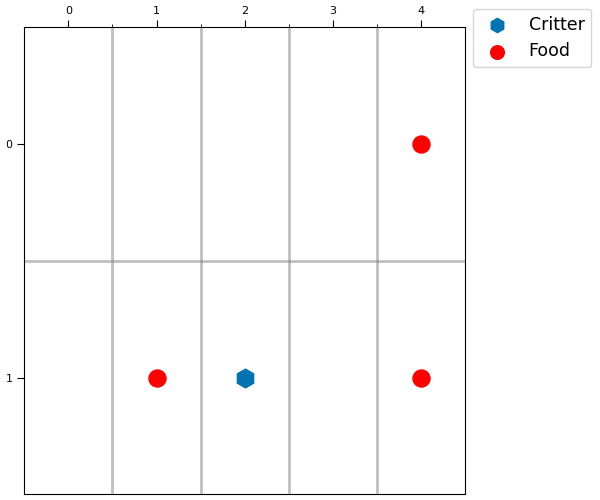

In [92]:
init_state = {
  'pieces': np.array([[[ 0,  0, 0, 0, -1,],
                       [ 0, -2, 1, 0, -3,]]], dtype=int),
  'scores': np.array([[0]]),
  'rounds_left': np.array([3]),
  'is_over': np.array([0])
}
gwg = GridworldGame(batch_size=1,
                    n_rows=2, n_cols=5,
                    num_foragers=1,
                    num_predators=0,
                    max_rounds_taken=5,
                    end_prob=0.0,
                    food_num_deterministic=True,
                    food_patch_prob=5/14,
                    food_forager_regen=False,
                    init_board_state=init_state)
s = gwg.get_init_board()
gwg.display(s, 0)
gwg.plot_board(s)
plt.show()

In [93]:
s = gwg.get_init_board()
s['rounds_left']

array([3])

In [94]:
# @title Gridworld, but shorter, smaller, and food doesn't regenerate
# @markdown Run this cell to try and eat as much food as possible in relatively few moves
igwg = InteractiveGridworld(
    gwg, players=['human'], critter_names=['You'],
    figsize=(5,4), has_fov=False)
display(igwg.b_fig.canvas)
clear_output()
display(igwg.final_display)


In [ ]:

gwg = GridworldGame(batch_size=1,
                    n_rows=5, n_cols=5,
                    num_foragers=1,
                    num_predators=0,)

complex_igwg = ComplexMoveInteractiveGridworld(
    gwg, players=[fast_rvp, 'human'], critter_names=['Prey', 'Pred(You!)'],
    figsize=(5,4), has_fov=True, radius=3, fov_opaque=True)
display(complex_igwg.b_fig.canvas)
display(complex_igwg.b_fig_legend.canvas)
clear_output()
display(complex_igwg.final_display)

# 1.4.1.1 Foraging in a patchy environment, two flavours.

In Seqeunce 1.2.3 on Normative thinking we introduced a patchy foraging game. The game from that sequence (vanilla here) is playable below.

In [ ]:
# @title Omniscient Patchy Foraging - Vanilla
# @markdown **Run this cell** to play the patchy foraging game.
rng = np.random.default_rng(1)
pfg = PatchyForagingGame(max_rounds_taken=20, food_patch_prob=0.3,
                         forage_success_prob=0.6, food_extinct_prob=0.2,
                         moves_cost=False, end_prob=0, rng=rng)
omni_ipfg = InteractivePatchyForage(pfg, show_food=True, show_misses=True,
                                    figsize=(4,5))
display(omni_ipfg.b_fig.canvas)
clear_output()
display(omni_ipfg.final_display)

In [ ]:
# @title Omniscient Patchy Foraging - Chocolate
# @markdown **Run this cell** to play the a slight variation on the previous patchy foraging game.
rng = np.random.default_rng(1)
pfg = PatchyForagingGame(max_rounds_taken=20, food_patch_prob=0.3,
                         forage_success_prob=0.6, food_extinct_prob=0.2,
                         moves_cost=True, end_prob=0, rng=rng)
omni_ipfg = InteractivePatchyForage(pfg, show_food=True, show_misses=True,
                                    figsize=(4,5))
display(omni_ipfg.b_fig.canvas)
clear_output()
display(omni_ipfg.final_display)

Can you spot the difference between the two variants? Hint: Look at what happens to the number of rounds left when you make a move (up, down, left, right) in each variant.

When we can see the food patches and tell when they have been exhausted, the optimal policy is similar in both scenarios. Move to a patch with food forager there until food is exhausted, then move on to the next patch with food. In the variant where moves are costly, some care needs to be taken so that patches with food are navagated to efficiently, much like in our earliest Gridworld foraging problems. But other than this requirement on efficient movement between patches, the decision about when to move on is identical when the state of food patches is known. However, in sequence 1.2.3 we focused on a more complex situation, where the presence or absence of food at a location was not immediately detectable, but rather could only be inferred from the recent history of foraging successes and failures at a given patch.

You can try out that variant of the game below

In [ ]:
# @title Cryptic Patchy Foraging - Moves Cost
# @markdown **Run this cell** to play the patchy foraging game with cryptic patches and movement has an opportunity cost.
rng = np.random.default_rng(3)
pfg = PatchyForagingGame(max_rounds_taken=20, food_patch_prob=0.3,
                         forage_success_prob=0.6, food_extinct_prob=0.2,
                         end_prob=0, moves_cost=True, rng=rng)
cryptic_ipfg = InteractivePatchyForage(pfg, show_food=False,
                                       show_misses=True,
                                       figsize=(4,5))
display(cryptic_ipfg.b_fig.canvas)
clear_output()
display(cryptic_ipfg.final_display)

While the variant where moves are free and the variant where moves have an opportunity cost are very similar in many ways, this slight difference, means that the approach we used to determine an optimal policy (behaviour rule) for one variant will not work for the other.

Consider, when movement between patches has no opportunity cost, all an optimal organism needs to worry about is foraging at a patch that has the highest possible probability of having food present. If that happens to be the patch the organism currently occupies, great, forage there, but if not, no problem, movement is free in some sense, so just move on to a fresh patch if the foraging odds are better there. In contrast, more nuance is required when time spent moving between patches uses up time that could have been spent foraging, i.e. when movement has an opportunity cost. To see this think about what happens when there is a single round left in the foraging episode. When movement is costly is there any situation where movement is preferable to foraging at the current patch on this last round? No, there is always some chance of success (from the forager's perspective) at the current patch, but there is zero chance of foraging success when moving, so an optimal forager would never move on the last round.

Things are certainly more complicated things, but the kind of thinking we applied in sequence 1.2.3 can be extended to find an optimal policy for this new, trickier problem.

# 1.4.1.2 Reasoning About The Problem

## **Defining the Problem**
First we need define our model problem precisely.

* **Patchy Environment**: The foraging environment consists of discrete patches (represented as grid cells). At the start of the simulation each patch has a probability $p_e \in (0,1)$ of containing food. The forager starts at a fresh patch.

* **Possible Actions**: In each turn, the organism has two options:
  - Try to forage at its current patch.
  - Move to a new patch.

* **Foraging Success**: When a patch contains food, foraging is often successful but not always guaranteed. In this model, foraging at a patch with food is successful with probability $p_s \in (0,1)$. Conversely, foraging on a food-less patch is certain to be unsuccessful.

* **Patch Exhaustion**: After each foraging success, there is a probability $p_x \in (0,1)$ that the patch becomes exhausted. In such cases, the patch won't provide any more food.

* **Session Limit**: The foragers can take a fixed number of actions, $T$, before the session end. Both move actions and foraging attemp actions count towards this limit.

* **Rewards**: Every successful foraging attempt gives the organism a reward of 1 point. If the foraging attempt is unsuccessful, no points are awarded for that round. Similarly, if the organism moves, no points are awarded. We denote the reward received on round $t$ as $R_t$.

* **Goal**: The overarching objective for the organism is to maximize its *expected cumulative reward* over the entire session. Formally, the forager aims to maximize:
$$
\mathbb{E}\left[ \sum_{t=1}^{T} R_t \right] = \sum_{t=1}^{T} \mathbb{E}\left[ R_t \right]
$$

Previously we kind of glossed over where exactly the actions of the forager were applied in the decision making process. We made simplifying assumptions (implicitly! Yikes!) that of course the forager would forage at a newly arrived patch (why else would it have moved these), but for a moment we're going to leave that aside and be as totally verbose and explicit as possible about all the different things that can happen. Just as a result of the foragers very first action.

In [ ]:
def latex_to_png(latex_str, file_path, dpi, fontsize, figsize):
  """Convert a LaTeX string to a PNG image."""
  fig, ax = plt.subplots(figsize=figsize)
  ax.text(0.5, 0.5, f"${latex_str}$", size=fontsize, ha='center', va='center')
  ax.axis("off")
  #plt.tight_layout()
  plt.subplots_adjust(left=0, right=1, top=1, bottom=0)
  plt.savefig(file_path, dpi=dpi, bbox_inches='tight', transparent=True, pad_inches=0.02)
  plt.close()

def add_latex_edge_labels(graph, edge_labels, dpi=150, fontsize=16, figsize=(0.4,0.2)):
  """Add LaTeX-rendered images as edge labels using the dummy node approach."""
  for edge in edge_labels:
    src, dest, latex_str = edge
    if graph.has_edge(src, dest):
      img_path = f"{src}_to_{dest}_{latex_str}.png"
      latex_to_png(latex_str, img_path, dpi=dpi, fontsize=fontsize, figsize=figsize)
      dummy_node_name = f"dummy_{src}_{dest}_{latex_str}"
      graph.add_node(dummy_node_name, shape="box", image=img_path, label="", color="green")
      graph.delete_edge(src, dest)
      graph.add_edge(src, dummy_node_name, dir="none", weight=10)
      graph.add_edge(dummy_node_name, dest, dir="forward", weight=10)
  return graph

def set_regular_node_sizes(graph, width=1.0, height=1.0):
  """Set the size of regular nodes (excluding dummy label nodes)."""
  for node in graph.nodes():
    if not node.startswith("dummy"):
      node.attr['width'] = width
      node.attr['height'] = height
  return graph


def create_and_render_graph(nodes_list, edges_list, latex_edge_labels,
                            action_nodes = [],
                            node_colors = {},
                            node_labels = {},
                            output_path="graphviz_output.png", dpi=300,
                            figsize=(0.6, 0.3), fontsize=16):
  """
  Create a graph with given nodes, edges, and LaTeX edge labels, then render and save it.

  Parameters:
    nodes_list (list): List of nodes in the graph.
    edges_list (list): List of edges in the graph.
    latex_edge_labels (list): List of tuples containing edge and its LaTeX label.
    output_path (str): Path to save the rendered graph.
    dpi (int): DPI for rendering the graph.
    figsize (tuple): Figure size for the LaTeX labels.

  Returns:
    str: Path to the saved graph image.
  """
  # Graph Creation and Configuration
  G = pgv.AGraph(directed=True, strict=False, rankdir='LR', ranksep=0.5, nodesep=0.5)

  # Add state and decision nodes
  for node in nodes_list:
    shape = "box" if node in action_nodes else "ellipse"  # Use 'box' for decision nodes
    if node in action_nodes:
      # action nodes are square and default to blue colour
      color = node_colors.get(node, "blue")
      shape = "box"
    else:
      # state nodes are round and default to black colour
      shape = "ellipse"
      color = node_colors.get(node, "black")
    label = node_labels.get(node, node)
    G.add_node(node, color=color, label=label, shape=shape)

  for edge in edges_list:
    G.add_edge(edge[0], edge[1])

  # Set size for regular nodes and add LaTeX-rendered image labels to the edges
  G = set_regular_node_sizes(G, width=1, height=1)
  G = add_latex_edge_labels(G, latex_edge_labels, dpi=dpi, figsize=figsize, fontsize=fontsize)

  # Additional graph attributes
  G.graph_attr['size'] = "8,8"
  G.graph_attr['dpi'] = str(dpi)

  # Render and save the graph
  G.layout(prog='dot')
  G.draw(output_path)

  return output_path

In [ ]:
# @markdown **Run This Cell** to visualize the decision tree


nodes_list = [
    "New Patch", "Has Food0", "No Food0", "Didn't Find Food0", "Found the Food0",
    "No Food to Find0", "Found Impossible Food0",
    "Search (has food)0", "Leave (has food)0",
    "Search (no food)0", "Leave (no food)0",
    "Has Food1", "No Food1", "Has Food2", "No Food2"
]

edges_list = [
    ("New Patch", "Has Food0"), ("New Patch", "No Food0"),
    ("Has Food0", "Search (has food)0"), ("Has Food0", "Leave (has food)0"),
    ("No Food0", "Search (no food)0"), ("No Food0", "Leave (no food)0"),
    ("Search (has food)0", "Found the Food0"), ("Search (has food)0", "Didn't Find Food0"),
    ("Search (no food)0", "Found Impossible Food0"), ("Search (no food)0", "No Food to Find0"),
    ("Leave (has food)0", "Has Food1"), ("Leave (has food)0", "No Food1"),
    ("Leave (no food)0", "Has Food2"), ("Leave (no food)0", "No Food2"),
]

latex_edge_labels = [
    ("New Patch", "Has Food0", "p_e"),
    ("New Patch", "No Food0", "1-p_e"),
    ("Search (has food)0", "Didn't Find Food0", "1-p_s"),
    ("Search (has food)0", "Found the Food0", "p_s"),
    ("Search (no food)0", "No Food to Find0", "1"),
    ("Search (no food)0", "Found Impossible Food0", "0"),
    ("Leave (has food)0", "No Food1", "p_e"),
    ("Leave (has food)0", "Has Food1", "1-p_e"),
    ("Leave (no food)0", "No Food2", "p_e"),
    ("Leave (no food)0", "Has Food2", "1-p_e")
]

action_nodes = [
    "Search (has food)0", "Search (no food)0", "Leave (has food)0", "Leave (no food)0"
]

node_colors = {
    "New Patch": "red",
    "Has Food0": "red",
    "No Food0": "red",
}

node_labels = {
    "Has Food0": "New Patch\nHas Food",
    "No Food0": "New Patch Has\nNo Food",
    "Has Food1": "New Patch\nHas Food",
    "No Food1": "New Patch Has\nNo Food",
    "Has Food2": "New Patch\nHas Food",
    "No Food2": "New Patch Has\nNo Food",
    "Search (has food)0": "Search",
    "Leave (has food)0": "Leave",
    "Search (no food)0": "Search",
    "Leave (no food)0": "Leave",
    "Didn't Find Food0": "No Food Found",
    "No Food to Find0": "No Food Found",
    "Found the Food0": "Food Found\n+1 Reward Point",
    "Found Impossible Food0": "Food Found\n+1 Reward Point"
}


output_path = create_and_render_graph(nodes_list, edges_list, latex_edge_labels,
                                      action_nodes=action_nodes,
                                      node_colors=node_colors,
                                      node_labels=node_labels)
Image(output_path, height=600)

In this diagram rounded nodes represent states of this process, i.e. the situation the organism is in with respect to the environment. Blue squares represent actions taken by the organism, and yellow squares give the probability of transitioning from the previous state, to the next state, given the action the organism took. These transitions can also be thought of as actions taken by the environment. This the full expansion, but looking at this we can see that if the organism leaves a patch, it doesn't matter whether or not there was food there, the state of the new patch is unaffected by this so we can already simplify this slightly.

In [ ]:
# @markdown **Run This Cell** to visualize the decision tree


nodes_list = [
  "New Patch", "Has Food0", "No Food0", "Didn't Find Food0", "Found the Food0",
  "No Food to Find0", "Found Impossible Food0",
  "Search (has food)0", "Leave0",
  "Search (no food)0",
  "Has Food1", "No Food1"
]

edges_list = [
  ("New Patch", "Has Food0"), ("New Patch", "No Food0"),
  ("Has Food0", "Search (has food)0"), ("Has Food0", "Leave0"),
  ("No Food0", "Search (no food)0"), ("No Food0", "Leave0"),
  ("Search (has food)0", "Found the Food0"), ("Search (has food)0", "Didn't Find Food0"),
  ("Search (no food)0", "Found Impossible Food0"), ("Search (no food)0", "No Food to Find0"),
  ("Leave0", "Has Food1"), ("Leave0", "No Food1"),
]

latex_edge_labels = [
  ("New Patch", "Has Food0", "p_e"),
  ("New Patch", "No Food0", "1-p_e"),
  ("Search (has food)0", "Didn't Find Food0", "1-p_s"),
  ("Search (has food)0", "Found the Food0", "p_s"),
  ("Search (no food)0", "No Food to Find0", "1"),
  ("Search (no food)0", "Found Impossible Food0", "0"),
  ("Leave0", "No Food1", "p_e"),
  ("Leave0", "Has Food1", "1-p_e"),
]

action_nodes = [
  "Search (has food)0", "Search (no food)0", "Leave0"
]

node_colors = {
    "New Patch": "red",
    "Has Food0": "red",
    "No Food0": "red",
}

node_labels = {
    "Has Food0": "New Patch\nHas Food",
    "No Food0": "New Patch Has\nNo Food",
    "Has Food1": "New Patch\nHas Food",
    "No Food1": "New Patch Has\nNo Food",
    "Search (has food)0": "Search",
    "Leave0": "Leave",
    "Search (no food)0": "Search",
    "Didn't Find Food0": "No Food Found",
    "No Food to Find0": "No Food Found",
    "Found the Food0": "Food Found\n+1 Reward Point",
    "Found Impossible Food0": "Food Found\n+1 Reward Point"
}


output_path = create_and_render_graph(nodes_list, edges_list, latex_edge_labels,
                                      action_nodes=action_nodes,
                                      node_colors=node_colors,
                                      node_labels=node_labels)
Image(output_path, height=600)

Similarly we can remove the zero probability event


In [ ]:
nodes_list = [
  "New Patch", "Has Food0", "No Food0", "Didn't Find Food0", "Found the Food0",
  "No Food to Find0",
  "Search (has food)0",
  "Search (has food)1"
  "Leave0",
  "Leave1"
  "Search (no food)0",
  "Search (no food)1",
  "Has Food1", "No Food1",
  "Search (didn't find food)0",
  "Search (found the food)0",
  "Search (no food to find)0",
  "Leave (didn't find food)0",
  "Leave (found the food)0",
  "Leave (no food to find)0",
]

edges_list = [
  ("New Patch", "Has Food0"), ("New Patch", "No Food0"),
  ("Has Food0", "Search (has food)0"), ("Has Food0", "Leave0"),
  ("No Food0", "Search (no food)0"), ("No Food0", "Leave0"),
  ("Search (has food)0", "Found the Food0"), ("Search (has food)0", "Didn't Find Food0"),
  ("Search (no food)0", "No Food to Find0"),
  ("Leave0", "Has Food1"), ("Leave0", "No Food1"),
]

latex_edge_labels = [
  ("New Patch", "Has Food0", "p_e"),
  ("New Patch", "No Food0", "1-p_e"),
  ("Search (has food)0", "Didn't Find Food0", "1-p_s"),
  ("Search (has food)0", "Found the Food0", "p_s"),
  ("Search (no food)0", "No Food to Find0", "1"),
  ("Leave0", "No Food1", "p_e"),
  ("Leave0", "Has Food1", "1-p_e"),
]

action_nodes = [
  "Search (has food)0", "Search (no food)0", "Leave0"
]

node_colors = {}

node_labels = {
    "Has Food0": "New Patch\nHas Food",
    "No Food0": "New Patch Has\nNo Food",
    "Has Food1": "New Patch\nHas Food",
    "No Food1": "New Patch Has\nNo Food",
    "Search (has food)0": "Search",
    "Leave0": "Leave",
    "Search (no food)0": "Search",
    "Didn't Find Food0": "No Food Found",
    "No Food to Find0": "No Food Found",
    "Found the Food0": "Food Found\n+1 Reward Point",
}


output_path = create_and_render_graph(nodes_list, edges_list, latex_edge_labels,
                                      action_nodes=action_nodes,
                                      node_colors=node_colors,
                                      node_labels=node_labels)
Image(output_path, height=600)

# MDP Notation
To get precise about what we are trying to optimize we first need to introduce some important notation, and formalize many of the general concepts introduced earlier in the book through our Gridworld example. If you are already farmiliar with these ideas feel free to skip this bit. Similarly if you find mathematical notation a bit overwhelming, you can also skim this section, (don't worry about understanding it all right away) and then use this as glossary as needed. A shortened version of these definitions also appear in the glossary/notation reference section found at the end of each notebook.

* $\pi_{\theta}(a|s)$: **Policy Function** - A policy is the behavioural blueprint for the organism. It's a function that takes (some representation or filtered down aspect of) the environmental state $s$ as input, and guided by its parameters $\theta$, gives the probability of taking action $a$, where $a$ is in the set $\mathcal{A}(s)$ of possible actions given state $s$. The organism can then sample an actio from this set according to these probabilities. Sometimes the explicit reference to $\theta$ is dropped when it is clear from context or does not need to be emphasized as in $\pi(a|s)$, other times the the reference to the parameters is made more explicit by writing $\pi(a | s, \theta)$. In our Gridworld example each of the organisms we defined, 'Random Valid', 'Parameterized Weights', 'Eat When Near' all had a policy function at their core.

* $s$: **A State** - The state represents a complete snapshot of what the environment looks like at a given moment. In our Gridworld example this is primarily the positions of food pieces and the organism, but also the number of rounds left in the simulation. The set of all possible states is denoted $\mathcal{S}$.

* $a$: **An Action** - The action an organism takes. Depending on how things are set up in our Gridworld example this might be represented as a direction or as a (row, columns) coordinate of the organism's new position, or as a flattened boolean index of the organism's new position. The set of all possible actions is denoted $\mathcal{A}$, and the set of possible actions in a given state as $\mathcal{A}(s)$.

* $r$ : **A Reward** - The immediate reward (feedback, score, points etc.) an organism recieves after taking an action $a$ in state $s$ and transitioning to new state $s'$. In our Gridworld example $r = 1$ if the organism eats a food piece as a result of its move and $r = 0$ otherwise.

* $\theta$: **Parameters** - The aspects of an organism's policy function that can be represented by numbers. Note that these do not describe the overall structure of the policy function, but rather determine a particular instance of the policy functions possible *given* the structure (archietecture) of a policy function. In our 'Parameterized Weights' policy from our Gridworld example, the connective weight strengths $W$ are the paramweters, i.e. $\theta = W$ in for this particular policy. For a more complicated policy with many layers of connective weights we might write $\theta = \{W_1, W_2,\dots, W_N \}$. We use $\theta$ as a generic term so that we can make general statements about parameterized policies without having to worry about the particular archiectecure or functional form of the policy.   

Given the stochastic nature of the environment (and often the policy as well), at any given time $t$ over the course of a simulation run, each of states, actions and rewards can be thought of as random variables specifically:

* $S_t$: **State at Time $t$** - A random variable that denotes the state of the environment at a specific time $t$. For example, $S_t = s$ means that at time $t$, in a particular simulation run, the environment was in state $s$, or in other words that $s$ is the realization of the random variable $S_t$.

* $A_t$: **Action at Time $t$** - A random variable denoting the action taken by the organism at time $t$. $A_t = a$ indicates that the action $a$ is taken at time $t$, or that $a$ is the realization of the random variable $A_t$ in a particular simulation run.

* $R_t$: **Reward at Time $t$** - A random variable indicating the immediate reward received by the organism at time $t$. $R_t = r$ indicates that the reward $r$ is obtained at time $t$, or in that $r$ is the realization of the random variable $R_t$ in a particular simulation run.

* $T$: **Total Simulation Time** - The total number of time steps in a given simulation. There are cases where having an infinite time horizon, $T=\infty$, is a mathematical convenience, but since our focus is on evolved, living and learning systems, and few things live forever, we will typically work with a finite time horizons.

* $t$: **Time-Step Index** - We typically subscript with $t$ to denote the value of a state, reward, action, etc. at a given specific time $t$.

We can then think of simulation run as sequence of random variables:
$$S_0, A_0, R_1, S_1, A_1, R_2, S_2, A_2, R_3, \dots, S_{T-1}, A_{T-1}, R_{T}, {S_T}$$

The dynamics, or equations of motion, that generate this sequence of random variables are primarily encapsulated in a *transition function*, together with an *initial state distribution*, both defined as follows.

* $p(s', r | s, a)$: **Transition Function** - Sometimes called the *State Transition Function*, or the *Transition Kernel* (kernel is more common when dealing with continuous state spaces) this function give the probability of transitioning from state $s$ to $s'$ and recieving reward $r$ from time-step $t$ to $t+1$, given that action $a$ is taken at time $t$. In terms of our previous notation this is defined as:
$$ p(s', r | s, a) := \Pr \{S_{t+1} = s' , R_{t+1} = r | S_t = s, A_t = a \}$$  

* $p_0(s)$: **Initial State Distribution** - This is the probability distribution (density function) over the set of possible states, \mathcal{S}, so $p_0(s) := \Pr \{S_0 = s\}$. Sometimes we write $S_0 \sim p_0$, which is read as 'The random variable $S_0$ is distributed according to the probability density function $p_0$'.

This random variable notation also allows us to make uur definition of a policy function more precise: $$\pi_{\theta}(a | s) := \Pr \{A_{t} = a | S_t = s\}.$$

Then, if a policy is fixed it can simply be folded into the dynamics of the environment, creating what is refered to as the *policy-induced dynamics*.

* $p_\pi(s', r | s)$: **Policy-Induced Dynamics** - This is also called the 'dynamics under policy $\pi$' and is defined as:
$$p_\pi(s', r | s):= \Pr \{S_{t+1} = s' , R_{t+1} = r | S_t = s, \pi \} = \sum_{a\in\mathcal{A}(s)} \pi_\theta (a | s) \ p(s', r | s, a).$$
Sometimes the depedence on a specific policy, $\pi$, is taken as implicit and we simply write $p(s', r | s)$.

The takeaway here is that for a fixed $\pi$ and a given transition function $p$ (and initial state distribution $p_0$) the stochastic dynamics of the system are completely determined.

With all that defined we can start to formally describe how rewards should be added up over time to define our goals. We just need to introduce the idea of a *Return* and a *Value* function.

* $G_t$: **Return following time $t$** - Sometimes called the reward to go, or simply the return, this a random variable that indicates the total reward yet to be realized after time $t$, i.e. $G_t := \sum_{k=t+1}^T R_k$.

* $v_{\pi}(s,t)$: **Value Function** - A function giving the *expected* return conditional on being in state $s$ at time $t$ and following a given policy $\pi$, specifically:
$$v_{\pi}(s,t) := \mathbb{E}_\pi \left[G_t | S_t = s \right].$$
In a slight stretch of notation $t$ can be treated as part of $s$ and we can write $v_{\pi}(s)$. The dependence on a specific policy is sometimes treated as implicit and we write $v(s)$ or $v(s,t)$.

In this context then our goal is to maximize the *Expectation* of a simulation run, or equivalently the average value from playing through many simulations (in the limit as many --> $\infty$). We call this formalization of our goal objective function and define our particular objective function in this context as

* $J(\theta)$: **Objective Function** - The function that we are trying to maximize, emphasizing the dependence on the parameters, $\theta$.

The objective function is in some ways the most subjective thing in this whole set up. It's what defines the "problem to be solved". In our particular case we we are going to use the following as our objective.

$$J(\theta):= \mathbb{E}\left[ v_{\pi_\theta}(S_0) \right] = \sum_{s \in \mathcal{S}} p_0(s) \cdot v_{\pi_{\theta}}(s)$$

Then the formalization of our problem is choosing parameters $\theta$ such that $J(\theta)$ is as high as possible. In general this goal is written as:
$$ \max_{\theta} J(\theta),$$

and in our particular case of maximizing the expected value, given a finite and discrete state space, our goal is written as:

$$ \max_\theta\sum_{s \in \mathcal{S}} p_0(s) \cdot v_{\pi_{\theta}}(s)$$

In [ ]:
# @markdown Submit your feedback
content_review(f"{feedback_prefix}_M3")

# Quiz

In [ ]:
# @markdown **Run this cell** to take the quiz
# @markdown **Run this cell** to take the quiz
comprehension_quiz = [
  {
    "question": "What is the impact of mutation on the evolutionary process?",
    "type": "multiple_choice",
    "answers": [
      {
        "answer": "It always increases the fitness of individuals in a population.",
        "correct": False,
        "feedback": "Mutation does not always increase fitness; it typically introduces neutral or deleterious variations. Beneficial mutations are rare."
      },
      {
        "answer": "It introduces necessary variation to explore new genotypes.",
        "correct": True,
        "feedback": "Correct! Mutation is essential for introducing genetic variation, which allows populations to explore new genotypes and adapt over time."
      },
      {
        "answer": "It decreases genetic diversity within a population.",
        "correct": False,
        "feedback": "Mutation actually increases genetic diversity by introducing new genetic variations."
      },
      {
        "answer": "It reduces the population size over time.",
        "correct": False,
        "feedback": "Mutation itself does not necessarily reduce population size; it's the selection process that might influence population numbers based on the fitness effects of mutations."
      }
    ]
  },
  {
    "question": "How does evolution compare to a typical optimization algorithm?",
    "type": "multiple_choice",
    "answers": [
      {
        "answer": "Evolution has a clear termination condition when a global maximum is reached.",
        "correct": False,
        "feedback": "Evolution lacks a termination condition and does not stop even when high-fitness solutions are found."
      },
      {
        "answer": "Evolution is a process that continually explores and exploits, without awareness of the global fitness landscape.",
        "correct": True,
        "feedback": "Exactly! Evolution continuously explores new genotypes and exploits current adaptations without a concept of the overall fitness landscape. In this way it is like a 'black-box' optimization algorithm"
      },
      {
        "answer": "Evolutionary processes always find the globally optimal solution.",
        "correct": False,
        "feedback": "Evolution does not necessarily find global optima; it often settles on local maxima due to its hill-climbing nature."
      },
      {
        "answer": "Evolution stops mutations once a sufficiently good solution is found.",
        "correct": False,
        "feedback": "Evolution does not stop mutating genotypes even after finding high-fitness solutions, which can lead to further, fitness reducing variation."
      }
    ]
  },
  {
    "question": "In the context of evolutionary simulations, what does a low mutation rate typically lead to?",
    "type": "multiple_choice",
    "answers": [
      {
        "answer": "A diverse population with many different genotypes coexisting.",
        "correct": False,
        "feedback": "A low mutation rate usually results in less genetic diversity, not more."
      },
      {
        "answer": "Rapid convergence to the global fitness peak.",
        "correct": False,
        "feedback": "Low mutation rates can lead to rapid convergence, but not necessarily to global peaks—often to local ones."
      },
      {
        "answer": "The population is generally dominated by a single variant.",
        "correct": True,
        "feedback": "Correct! Low mutation rates can lead to populations being dominated by a single, high-fitness variant."
      },
      {
        "answer": "An increase in the number of harmful mutations.",
        "correct": False,
        "feedback": "A low mutation rate means fewer mutations overall, not an increase in harmful ones specifically."
      }
    ]
  },
  {
    "question": "What role do 'sticky attractors' play in evolutionary processes?",
    "type": "multiple_choice",
    "answers": [
      {
        "answer": "They prevent the population from reaching any kind of fitness peak.",
        "correct": False,
        "feedback": "Sticky attractors do not prevent the attainment of fitness peaks; they are the peaks where populations tend to stabilize."
      },
      {
        "answer": "They represent states of low fitness that populations tend to avoid.",
        "correct": False,
        "feedback": "Sticky attractors are not low-fitness states; they are high-fitness states that populations are drawn to."
      },
      {
        "answer": "They are high-fitness states in the genotype space that populations are likely to remain in for long periods.",
        "correct": True,
        "feedback": "Exactly! Sticky attractors are robust high-fitness states where populations tend to remain stable over time."
      },
      {
        "answer": "They are synonymous with global maxima in the fitness function.",
        "correct": False,
        "feedback": "Sticky attractors correspond to local maxima, not necessarily global maxima, in the fitness landscape."
      }
    ]
  }
]

display_quiz(comprehension_quiz)